In [1]:
import pandas as pd
import numpy as np

cds_tab = pd.read_csv(
    '../data/CCDS.current.txt.gz', # downloaded 4th of May 2025
    sep = '\t',
    compression = 'gzip'
)
    
cds_tab = cds_tab.loc[cds_tab.ccds_status.str.match('Public')]
for column in ['cds_from', 'cds_to']:
    cds_tab.loc[:, column] = cds_tab[column].apply(
        lambda x: int(x) if x.isnumeric() else 0
    )
    
cds_tab['cds_length'] = cds_tab.cds_to - cds_tab.cds_from
cds_tab = cds_tab.loc[cds_tab.groupby('gene_id')['cds_length'].idxmax()]
cds_tab.set_index('ccds_id', inplace=True)
cds_tab

#chromosome  nc_accession          gene    gene_id ccds_status  \
ccds_id                                                                      
CCDS12976.1          19  NC_000019.10          A1BG          1      Public   
CCDS44827.1          12  NC_000012.12           A2M          2      Public   
CCDS55205.1           8  NC_000008.11          NAT1          9      Public   
CCDS6008.1            8  NC_000008.11          NAT2         10      Public   
CCDS32150.1          14   NC_000014.9      SERPINA3         12      Public   
...                 ...           ...           ...        ...         ...   
CCDS92674.1          19  NC_000019.10  LOC122539214  122539214      Public   
CCDS92289.1          17  NC_000017.11         H2BN1  124188214      Public   
CCDS93007.1          20  NC_000020.11  LOC128706665  128706665      Public   
CCDS93006.1          20  NC_000020.11  LOC128706666  128706666      Public   
CCDS53542.1          10  NC_000010.11       DUSP13A  128854680      Public   

            cds_strand  cds_from    cds_to  \
ccds_id                                      
CCDS12976.1          -  58347021  58353436   
CCDS44827.1          -   9067822   9115848   
CCDS55205.1          +  18216893  18222919   
CCDS6008.1           +  18400003  18400875   
CCDS32150.1          +  94614441  94623813   
...                ...       ...       ...   
CCDS92674.1          -  52652667  52660823   
CCDS92289.1          +  32895432  32906372   
CCDS93007.1          -  10420545  10420736   
CCDS93006.1          -  10413734  10413886   
CCDS53542.1          -  75105668  75109156   

                                                 cds_locations match_type  \
ccds_id                                                                     
CCDS12976.1  [58347021-58347028, 58347352-58347639, 5835036...  Identical   
CCDS44827.1  [9067822-9067838, 9068182-9068223, 9068739-906...  Identical   
CCDS55205.1  [18216893-18216993, 18219410-18219488, 1822204...  Identical   
CCDS6008.1                                 [18400003-18400875]  Identical   
CCDS32150.1  [94614441-94615083, 94619194-94619467, 9462234...  Identical   
...                                                        ...        ...   
CCDS92674.1  [52652667-52654402, 52655560-52655686, 5266076...  Identical   
CCDS92289.1             [32895432-32895605, 32906190-32906372]  Identical   
CCDS93007.1                                [10420545-10420736]  Identical   
CCDS93006.1                                [10413734-10413886]  Identical   
CCDS53542.1  [75105668-75105867, 75107991-75108208, 7510900...  Identical   

            cds_length  
ccds_id                 
CCDS12976.1       6415  
CCDS44827.1      48026  
CCDS55205.1       6026  
CCDS6008.1         872  
CCDS32150.1       9372  
...                ...  
CCDS92674.1       8156  
CCDS92289.1      10940  
CCDS93007.1        191  
CCDS93006.1        152  
CCDS53542.1       3488  

[19085 rows x 11 columns]

In [2]:
import gzip
from codontools import count

cdss = {}
valid_cds_ids = set(cds_tab.index.unique())
with gzip.open('../data/CCDS_nucleotide.current.fna.gz', 'rt') as seqfile:
    cds_id = seqfile.readline().split('|', maxsplit=1)[0] # get first cds_id here for cleaner code
    sequences = []
    for line in seqfile:
        if line.startswith('>'):
            if cds_id in valid_cds_ids:
                gene_name = cds_tab.loc[cds_id, 'gene']
                cdss[gene_name] = ''.join(sequences)
            
            cds_id = line.split('|', maxsplit=1)[0][1:]
            sequences = []
        
        else:
            sequences.append(line.rstrip())

cdss = pd.Series(cdss)
    
codon_frame = count.count_codons_per_cds(cdss)
codon_frame

AAA  AAC  AAG  AAT  ACA  ACC  ACG  ACT  AGA  AGC  ...  TCG  TCT  \
NOC2L       6   13   36    5    3   12    7    7    8   24  ...   12    9   
PLEKHN1     1    9   16    0    7   11    6    2    5   19  ...   12    5   
HES4        3    2    7    0    0    4    2    0    2    8  ...    4    0   
ISG15       1    2    7    2    1    5    3    0    0   11  ...    1    0   
C1orf159    2    7    3    1    0    2    3    0    4    8  ...    0    0   
...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
PWWP4      30   16   61    8   20   38   27   71   16   35  ...    6   43   
ZNF275      8    3   24    5    1    6    1    3    4   12  ...    5    4   
TSPY9       1    8   11    4    2    4    1    2    2    5  ...    1    5   
UTY        58   25   30   64   38   16    2   29   19   23  ...    3   40   
DAZ2        6    4    5   33    0   14    2   26    7    3  ...    1    3   

          TGA  TGC  TGG  TGT  TTA  TTC  TTG  TTT  
NOC2L       1   12    8    3    0   30    4    4  
PLEKHN1     1   11    7    2    1   13    5    1  
HES4        1    2    2    1    0    3    0    0  
ISG15       0    1    2    0    0    5    0    0  
C1orf159    1    4    1    5    0    7    0    1  
...       ...  ...  ...  ...  ...  ...  ...  ...  
PWWP4       0   31   25    9    4    7   11   14  
ZNF275      0   17    1    7    1   14    2    6  
TSPY9       1    1    4    3    0    9    6    2  
UTY         0   12   23   26   26   12   40   27  
DAZ2        1    2    5    3    3    6   15   37  

[19084 rows x 64 columns]

In [3]:
codon_freqs = codon_frame.divide(codon_frame.sum(axis=1), axis=0)
codon_freqs

AAA       AAC       AAG       AAT       ACA       ACC  \
NOC2L     0.008000  0.017333  0.048000  0.006667  0.004000  0.016000   
PLEKHN1   0.001634  0.014706  0.026144  0.000000  0.011438  0.017974   
HES4      0.013514  0.009009  0.031532  0.000000  0.000000  0.018018   
ISG15     0.006024  0.012048  0.042169  0.012048  0.006024  0.030120   
C1orf159  0.010050  0.035176  0.015075  0.005025  0.000000  0.010050   
...            ...       ...       ...       ...       ...       ...   
PWWP4     0.014549  0.007759  0.029583  0.003880  0.009699  0.018429   
ZNF275    0.018605  0.006977  0.055814  0.011628  0.002326  0.013953   
TSPY9     0.003175  0.025397  0.034921  0.012698  0.006349  0.012698   
UTY       0.040759  0.017569  0.021082  0.044975  0.026704  0.011244   
DAZ2      0.009160  0.006107  0.007634  0.050382  0.000000  0.021374   

               ACG       ACT       AGA       AGC  ...       TCG       TCT  \
NOC2L     0.009333  0.009333  0.010667  0.032000  ...  0.016000  0.012000   
PLEKHN1   0.009804  0.003268  0.008170  0.031046  ...  0.019608  0.008170   
HES4      0.009009  0.000000  0.009009  0.036036  ...  0.018018  0.000000   
ISG15     0.018072  0.000000  0.000000  0.066265  ...  0.006024  0.000000   
C1orf159  0.015075  0.000000  0.020101  0.040201  ...  0.000000  0.000000   
...            ...       ...       ...       ...  ...       ...       ...   
PWWP4     0.013094  0.034433  0.007759  0.016974  ...  0.002910  0.020854   
ZNF275    0.002326  0.006977  0.009302  0.027907  ...  0.011628  0.009302   
TSPY9     0.003175  0.006349  0.006349  0.015873  ...  0.003175  0.015873   
UTY       0.001405  0.020379  0.013352  0.016163  ...  0.002108  0.028110   
DAZ2      0.003053  0.039695  0.010687  0.004580  ...  0.001527  0.004580   

               TGA       TGC       TGG       TGT       TTA       TTC  \
NOC2L     0.001333  0.016000  0.010667  0.004000  0.000000  0.040000   
PLEKHN1   0.001634  0.017974  0.011438  0.003268  0.001634  0.021242   
HES4      0.004505  0.009009  0.009009  0.004505  0.000000  0.013514   
ISG15     0.000000  0.006024  0.012048  0.000000  0.000000  0.030120   
C1orf159  0.005025  0.020101  0.005025  0.025126  0.000000  0.035176   
...            ...       ...       ...       ...       ...       ...   
PWWP4     0.000000  0.015034  0.012124  0.004365  0.001940  0.003395   
ZNF275    0.000000  0.039535  0.002326  0.016279  0.002326  0.032558   
TSPY9     0.003175  0.003175  0.012698  0.009524  0.000000  0.028571   
UTY       0.000000  0.008433  0.016163  0.018271  0.018271  0.008433   
DAZ2      0.001527  0.003053  0.007634  0.004580  0.004580  0.009160   

               TTG       TTT  
NOC2L     0.005333  0.005333  
PLEKHN1   0.008170  0.001634  
HES4      0.000000  0.000000  
ISG15     0.000000  0.000000  
C1orf159  0.000000  0.005025  
...            ...       ...  
PWWP4     0.005335  0.006790  
ZNF275    0.004651  0.013953  
TSPY9     0.019048  0.006349  
UTY       0.028110  0.018974  
DAZ2      0.022901  0.056489  

[19084 rows x 64 columns]

In [4]:
codons_of_interest_G = ['AAG', 'GAG', 'CAG', 'AGG']
codons_of_interest_A = ['AAA', 'GAA', 'CAA', 'AGA']
codons_of_interest_all = codons_of_interest_G + codons_of_interest_A
codons_of_interest = {
    'Aend': codons_of_interest_A, 
    'Gend': codons_of_interest_G, 
    'AGend': codons_of_interest_all
}
frames = []
for key, codons in codons_of_interest.items():
    frame = pd.DataFrame(
        codon_freqs[codons].sum(axis=1), 
        columns = [f'{key}_freq']
    )
    frames.append(frame)
    
accumulated_coi_freqs = pd.concat(
    frames,
    axis = 1
)
accumulated_coi_freqs

Aend_freq  Gend_freq  AGend_freq
NOC2L      0.049333   0.178667    0.228000
PLEKHN1    0.021242   0.137255    0.158497
HES4       0.022523   0.108108    0.130631
ISG15      0.024096   0.162651    0.186747
C1orf159   0.035176   0.075377    0.110553
...             ...        ...         ...
PWWP4      0.041222   0.108147    0.149370
ZNF275     0.051163   0.183721    0.234884
TSPY9      0.044444   0.200000    0.244444
UTY        0.116655   0.078707    0.195362
DAZ2       0.041221   0.116031    0.157252

[19084 rows x 3 columns]

In [5]:
def read_data(filename, selected_columns, index_col):
    df = pd.read_csv(
        filename,
        sep = '\t'
    )
    df.set_index(
        index_col,
        inplace = True
    )
    if not selected_columns:
        return df
    
    df = df.loc[:, selected_columns.keys()]
    df.rename(
        columns = selected_columns,
        inplace = True
    )
    return df

    
select_columns = {
    'H_dox: -Log(P-value)': 'Dox72h_vs_ctrl -log(pval)',
    'H_dox: Difference': 'Dox72h_vs_ctrl diff',
    'H_dox: Significant Class A': 'Dox72h_vs_ctrl significant',
    'H_res: -Log(P-value)': 'CTU2res_vs_ctrl -log(pval)',
    'H_res: Difference': 'CTU2res_vs_ctrl diff', 
    'H_res: Significant Class A': 'CTU2res_vs_ctrl significant',
    'H_scr: -Log(P-value)': 'scramble_vs_ctrl -log(pval)',
    'H_scr: Difference': 'scramble_vs_ctrl diff',
    'H_scr: Significant Class A': 'scramble_vs_ctrl significant',
    'Gene names': 'symbol'
}
hela = read_data(
    '../../Downloads/PCC_229/PCC_229_HeLa/Diff_Abundacne_Analysis.txt',
    select_columns,
    'Protein IDs'
)
hela

Dox72h_vs_ctrl -log(pval)  Dox72h_vs_ctrl diff  \
Protein IDs                                                             
sp|Q70J99|UN13D_HUMAN                   0.127206            -0.005308   
sp|P20290|BTF3_HUMAN                    3.913469            -0.130232   
sp|A6NDU8|RIMC1_HUMAN                   1.160422            -0.087100   
sp|P05783|K1C18_HUMAN                   4.308775            -0.156744   
sp|Q06265|EXOS9_HUMAN                   0.264936             0.027058   
...                                          ...                  ...   
sp|Q96CG3|TIFA_HUMAN                    0.243387            -0.085135   
sp|Q8N6I1|EID2_HUMAN                    0.377462            -0.274176   
sp|Q9Y2J4|AMOL2_HUMAN                   1.484418             0.186890   
sp|Q8NFP4|MDGA1_HUMAN                   0.585086             0.130634   
sp|A6NEE1|PLHD1_HUMAN                   1.258023             0.318116   

                      Dox72h_vs_ctrl significant  CTU2res_vs_ctrl -log(pval)  \
Protein IDs                                                                    
sp|Q70J99|UN13D_HUMAN                        NaN                    1.077641   
sp|P20290|BTF3_HUMAN                         NaN                    0.849110   
sp|A6NDU8|RIMC1_HUMAN                        NaN                    0.518637   
sp|P05783|K1C18_HUMAN                        NaN                    5.942210   
sp|Q06265|EXOS9_HUMAN                        NaN                    0.831099   
...                                          ...                         ...   
sp|Q96CG3|TIFA_HUMAN                         NaN                    0.073329   
sp|Q8N6I1|EID2_HUMAN                         NaN                    0.983688   
sp|Q9Y2J4|AMOL2_HUMAN                        NaN                    0.225603   
sp|Q8NFP4|MDGA1_HUMAN                        NaN                    0.575985   
sp|A6NEE1|PLHD1_HUMAN                        NaN                    0.014534   

                       CTU2res_vs_ctrl diff CTU2res_vs_ctrl significant  \
Protein IDs                                                               
sp|Q70J99|UN13D_HUMAN              0.045915                         NaN   
sp|P20290|BTF3_HUMAN              -0.034196                         NaN   
sp|A6NDU8|RIMC1_HUMAN             -0.032109                         NaN   
sp|P05783|K1C18_HUMAN             -0.282790                           +   
sp|Q06265|EXOS9_HUMAN              0.059332                         NaN   
...                                     ...                         ...   
sp|Q96CG3|TIFA_HUMAN              -0.024373                         NaN   
sp|Q8N6I1|EID2_HUMAN              -0.881346                         NaN   
sp|Q9Y2J4|AMOL2_HUMAN             -0.062727                         NaN   
sp|Q8NFP4|MDGA1_HUMAN              0.148563                         NaN   
sp|A6NEE1|PLHD1_HUMAN             -0.005353                         NaN   

                       scramble_vs_ctrl -log(pval)  scramble_vs_ctrl diff  \
Protein IDs                                                                 
sp|Q70J99|UN13D_HUMAN                     7.304551               0.406835   
sp|P20290|BTF3_HUMAN                      5.137598              -0.249056   
sp|A6NDU8|RIMC1_HUMAN                     0.821485              -0.046810   
sp|P05783|K1C18_HUMAN                     5.500796              -0.222636   
sp|Q06265|EXOS9_HUMAN                     1.718383              -0.138654   
...                                            ...                    ...   
sp|Q96CG3|TIFA_HUMAN                      0.838168              -0.203307   
sp|Q8N6I1|EID2_HUMAN                      0.249133               0.146140   
sp|Q9Y2J4|AMOL2_HUMAN                     3.180298               0.607181   
sp|Q8NFP4|MDGA1_HUMAN                     0.014458               0.005870   
sp|A6NEE1|PLHD1_HUMAN                     0.054322              -0.024731   

                      scramble_vs_ctrl significant   s

In [6]:
import numpy as np

hela_scramble_sig_proteins = set(hela.index[hela['scramble_vs_ctrl significant'] == '+'])
hela_dox_sig_proteins = set(hela.index[hela['Dox72h_vs_ctrl significant'] == '+'])
hela_dox_only_sig = hela_dox_sig_proteins - hela_scramble_sig_proteins
hela['Dox72h_only significant'] = None
hela.loc[list(hela_dox_only_sig), 'Dox72h_only significant'] = '+'
hela

Dox72h_vs_ctrl -log(pval)  Dox72h_vs_ctrl diff  \
Protein IDs                                                             
sp|Q70J99|UN13D_HUMAN                   0.127206            -0.005308   
sp|P20290|BTF3_HUMAN                    3.913469            -0.130232   
sp|A6NDU8|RIMC1_HUMAN                   1.160422            -0.087100   
sp|P05783|K1C18_HUMAN                   4.308775            -0.156744   
sp|Q06265|EXOS9_HUMAN                   0.264936             0.027058   
...                                          ...                  ...   
sp|Q96CG3|TIFA_HUMAN                    0.243387            -0.085135   
sp|Q8N6I1|EID2_HUMAN                    0.377462            -0.274176   
sp|Q9Y2J4|AMOL2_HUMAN                   1.484418             0.186890   
sp|Q8NFP4|MDGA1_HUMAN                   0.585086             0.130634   
sp|A6NEE1|PLHD1_HUMAN                   1.258023             0.318116   

                      Dox72h_vs_ctrl significant  CTU2res_vs_ctrl -log(pval)  \
Protein IDs                                                                    
sp|Q70J99|UN13D_HUMAN                        NaN                    1.077641   
sp|P20290|BTF3_HUMAN                         NaN                    0.849110   
sp|A6NDU8|RIMC1_HUMAN                        NaN                    0.518637   
sp|P05783|K1C18_HUMAN                        NaN                    5.942210   
sp|Q06265|EXOS9_HUMAN                        NaN                    0.831099   
...                                          ...                         ...   
sp|Q96CG3|TIFA_HUMAN                         NaN                    0.073329   
sp|Q8N6I1|EID2_HUMAN                         NaN                    0.983688   
sp|Q9Y2J4|AMOL2_HUMAN                        NaN                    0.225603   
sp|Q8NFP4|MDGA1_HUMAN                        NaN                    0.575985   
sp|A6NEE1|PLHD1_HUMAN                        NaN                    0.014534   

                       CTU2res_vs_ctrl diff CTU2res_vs_ctrl significant  \
Protein IDs                                                               
sp|Q70J99|UN13D_HUMAN              0.045915                         NaN   
sp|P20290|BTF3_HUMAN              -0.034196                         NaN   
sp|A6NDU8|RIMC1_HUMAN             -0.032109                         NaN   
sp|P05783|K1C18_HUMAN             -0.282790                           +   
sp|Q06265|EXOS9_HUMAN              0.059332                         NaN   
...                                     ...                         ...   
sp|Q96CG3|TIFA_HUMAN              -0.024373                         NaN   
sp|Q8N6I1|EID2_HUMAN              -0.881346                         NaN   
sp|Q9Y2J4|AMOL2_HUMAN             -0.062727                         NaN   
sp|Q8NFP4|MDGA1_HUMAN              0.148563                         NaN   
sp|A6NEE1|PLHD1_HUMAN             -0.005353                         NaN   

                       scramble_vs_ctrl -log(pval)  scramble_vs_ctrl diff  \
Protein IDs                                                                 
sp|Q70J99|UN13D_HUMAN                     7.304551               0.406835   
sp|P20290|BTF3_HUMAN                      5.137598              -0.249056   
sp|A6NDU8|RIMC1_HUMAN                     0.821485              -0.046810   
sp|P05783|K1C18_HUMAN                     5.500796              -0.222636   
sp|Q06265|EXOS9_HUMAN                     1.718383              -0.138654   
...                                            ...                    ...   
sp|Q96CG3|TIFA_HUMAN                      0.838168              -0.203307   
sp|Q8N6I1|EID2_HUMAN                      0.249133               0.146140   
sp|Q9Y2J4|AMOL2_HUMAN                     3.180298               0.607181   
sp|Q8NFP4|MDGA1_HUMAN                     0.014458               0.005870   
sp|A6NEE1|PLHD1_HUMAN                     0.054322              -0.024731   

                      scramble_vs_ctrl significant   s

In [7]:
hela_scramble_sig_up_proteins = set(
    hela.index[
        (hela['scramble_vs_ctrl significant'] == '+') & 
        (hela['scramble_vs_ctrl diff'] > 0)
    ]
)
hela_scramble_sig_down_proteins = set(
    hela.index[
        (hela['scramble_vs_ctrl significant'] == '+') & 
        (hela['scramble_vs_ctrl diff'] < 0)
    ]
)
hela_dox_sig_up_proteins = set(
    hela.index[
        (hela['Dox72h_vs_ctrl significant'] == '+') &
        (hela['Dox72h_vs_ctrl diff'] > 0)
    ]
)
hela_dox_sig_down_proteins = set(
    hela.index[
        (hela['Dox72h_vs_ctrl significant'] == '+') &
        (hela['Dox72h_vs_ctrl diff'] < 0)
    ]
)
hela_dox_only_updown_sig = (hela_dox_sig_up_proteins - hela_scramble_sig_up_proteins) | (hela_dox_sig_down_proteins - hela_scramble_sig_down_proteins)
hela['Dox72h_updown_only significant'] = None
hela.loc[list(hela_dox_only_updown_sig), 'Dox72h_updown_only significant'] = '+'
hela

Dox72h_vs_ctrl -log(pval)  Dox72h_vs_ctrl diff  \
Protein IDs                                                             
sp|Q70J99|UN13D_HUMAN                   0.127206            -0.005308   
sp|P20290|BTF3_HUMAN                    3.913469            -0.130232   
sp|A6NDU8|RIMC1_HUMAN                   1.160422            -0.087100   
sp|P05783|K1C18_HUMAN                   4.308775            -0.156744   
sp|Q06265|EXOS9_HUMAN                   0.264936             0.027058   
...                                          ...                  ...   
sp|Q96CG3|TIFA_HUMAN                    0.243387            -0.085135   
sp|Q8N6I1|EID2_HUMAN                    0.377462            -0.274176   
sp|Q9Y2J4|AMOL2_HUMAN                   1.484418             0.186890   
sp|Q8NFP4|MDGA1_HUMAN                   0.585086             0.130634   
sp|A6NEE1|PLHD1_HUMAN                   1.258023             0.318116   

                      Dox72h_vs_ctrl significant  CTU2res_vs_ctrl -log(pval)  \
Protein IDs                                                                    
sp|Q70J99|UN13D_HUMAN                        NaN                    1.077641   
sp|P20290|BTF3_HUMAN                         NaN                    0.849110   
sp|A6NDU8|RIMC1_HUMAN                        NaN                    0.518637   
sp|P05783|K1C18_HUMAN                        NaN                    5.942210   
sp|Q06265|EXOS9_HUMAN                        NaN                    0.831099   
...                                          ...                         ...   
sp|Q96CG3|TIFA_HUMAN                         NaN                    0.073329   
sp|Q8N6I1|EID2_HUMAN                         NaN                    0.983688   
sp|Q9Y2J4|AMOL2_HUMAN                        NaN                    0.225603   
sp|Q8NFP4|MDGA1_HUMAN                        NaN                    0.575985   
sp|A6NEE1|PLHD1_HUMAN                        NaN                    0.014534   

                       CTU2res_vs_ctrl diff CTU2res_vs_ctrl significant  \
Protein IDs                                                               
sp|Q70J99|UN13D_HUMAN              0.045915                         NaN   
sp|P20290|BTF3_HUMAN              -0.034196                         NaN   
sp|A6NDU8|RIMC1_HUMAN             -0.032109                         NaN   
sp|P05783|K1C18_HUMAN             -0.282790                           +   
sp|Q06265|EXOS9_HUMAN              0.059332                         NaN   
...                                     ...                         ...   
sp|Q96CG3|TIFA_HUMAN              -0.024373                         NaN   
sp|Q8N6I1|EID2_HUMAN              -0.881346                         NaN   
sp|Q9Y2J4|AMOL2_HUMAN             -0.062727                         NaN   
sp|Q8NFP4|MDGA1_HUMAN              0.148563                         NaN   
sp|A6NEE1|PLHD1_HUMAN             -0.005353                         NaN   

                       scramble_vs_ctrl -log(pval)  scramble_vs_ctrl diff  \
Protein IDs                                                                 
sp|Q70J99|UN13D_HUMAN                     7.304551               0.406835   
sp|P20290|BTF3_HUMAN                      5.137598              -0.249056   
sp|A6NDU8|RIMC1_HUMAN                     0.821485              -0.046810   
sp|P05783|K1C18_HUMAN                     5.500796              -0.222636   
sp|Q06265|EXOS9_HUMAN                     1.718383              -0.138654   
...                                            ...                    ...   
sp|Q96CG3|TIFA_HUMAN                      0.838168              -0.203307   
sp|Q8N6I1|EID2_HUMAN                      0.249133               0.146140   
sp|Q9Y2J4|AMOL2_HUMAN                     3.180298               0.607181   
sp|Q8NFP4|MDGA1_HUMAN                     0.014458               0.005870   
sp|A6NEE1|PLHD1_HUMAN                     0.054322              -0.024731   

                      scramble_vs_ctrl significant   s

In [8]:
select_columns = {
    'R_dox_96: -Log(P-value)': 'Dox96_vs_Dox48h -log(pval)',
    'R_dox_96: Difference': 'Dox96_vs_Dox48h diff',
    'R_dox_96: Significant Class A': 'Dox96_vs_Dox48h significant',
    'R_scr: -Log(P-value)': 'scramble_vs_Dox48h -log(pval)',
    'R_scr: Difference': 'scramble_vs_Dox48h diff',
    'R_scr: Significant Class A': 'scramble_vs_Dox48h significant',
    'Gene names': 'symbol'
}
rpe1_dox48 = read_data(
    '../../Downloads/PCC_232/PCC_232_RPE1/Diff_abundance_Dox48.txt',
    select_columns,
    'Protein IDs'
)
rpe1_dox48

Dox96_vs_Dox48h -log(pval)  \
Protein IDs                                                               
sp|P10809|CH60_HUMAN                                           1.109003   
sp|P13639|EF2_HUMAN                                            0.070712   
sp|Q6VY07|PACS1_HUMAN;sp|Q86VP3|PACS2_HUMAN                    0.095907   
sp|Q9NX62|IMPA3_HUMAN                                          2.115870   
sp|P18206|VINC_HUMAN                                           0.233035   
...                                                                 ...   
sp|P53803|RPAB4_HUMAN                                          1.662821   
sp|Q9P215|POGK_HUMAN                                           0.895292   
sp|Q969K4|ABTB1_HUMAN                                          0.344112   
sp|Q7Z6M2|FBX33_HUMAN                                          2.533192   
sp|Q9NPE2|NGRN_HUMAN                                           0.430840   

                                             Dox96_vs_Dox48h diff  \
Protein IDs                                                         
sp|P10809|CH60_HUMAN                                     0.058368   
sp|P13639|EF2_HUMAN                                     -0.009332   
sp|Q6VY07|PACS1_HUMAN;sp|Q86VP3|PACS2_HUMAN             -0.009264   
sp|Q9NX62|IMPA3_HUMAN                                   -0.125007   
sp|P18206|VINC_HUMAN                                     0.017665   
...                                                           ...   
sp|P53803|RPAB4_HUMAN                                    0.169664   
sp|Q9P215|POGK_HUMAN                                    -0.210994   
sp|Q969K4|ABTB1_HUMAN                                   -0.167121   
sp|Q7Z6M2|FBX33_HUMAN                                   -0.509278   
sp|Q9NPE2|NGRN_HUMAN                                    -0.156941   

                                            Dox96_vs_Dox48h significant  \
Protein IDs                                                               
sp|P10809|CH60_HUMAN                                                NaN   
sp|P13639|EF2_HUMAN                                                 NaN   
sp|Q6VY07|PACS1_HUMAN;sp|Q86VP3|PACS2_HUMAN                         NaN   
sp|Q9NX62|IMPA3_HUMAN                                               NaN   
sp|P18206|VINC_HUMAN                                                NaN   
...                                                                 ...   
sp|P53803|RPAB4_HUMAN                                               NaN   
sp|Q9P215|POGK_HUMAN                                                NaN   
sp|Q969K4|ABTB1_HUMAN                                               NaN   
sp|Q7Z6M2|FBX33_HUMAN                                                 +   
sp|Q9NPE2|NGRN_HUMAN                                                NaN   

                                             scramble_vs_Dox48h -log(pval)  \
Protein IDs                                                                  
sp|P10809|CH60_HUMAN                                              0.301276   
sp|P13639|EF2_HUMAN                                               2.215887   
sp|Q6VY07|PACS1_HUMAN;sp|Q86VP3|PACS2_HUMAN                       1.094014   
sp|Q9NX62|IMPA3_HUMAN                                             0.233086   
sp|P18206|VINC_HUMAN                                              1.554736   
...                                                                    ...   
sp|P53803|RPAB4_HUMAN                                             1.443686   
sp|Q9P215|POGK_HUMAN                                              1.015799   
sp|Q969K4|ABTB1_HUMAN                                             1.958923   
sp|Q7Z6M2|FBX33_HUMAN                                             0.088470   
sp|Q9NPE2|NGRN_HUMAN                                              0.916880   

                                             scramble_vs_Dox48h diff  \
Protein IDs                                                            
sp|P10809|CH60_HUMAN                

In [9]:
select_columns = {
    'R_dox_48: -Log(P-value)': 'Dox48h_vs_ctrl -log(pval)',
    'R_dox_48: Difference': 'Dox48h_vs_ctrl diff',
    'R_dox_48: Significant Class A': 'Dox48h_vs_ctrl significant',
    'R_dox_96: -Log(P-value)': 'Dox96h_vs_ctrl -log(pval)',
    'R_dox_96: Difference': 'Dox96h_vs_ctrl diff',
    'R_dox_96: Significant Class A': 'Dox96h_vs_ctrl significant',
    'R_scr: -Log(P-value)': 'scramble_vs_ctrl -log(pval)',
    'R_scr: Difference': 'scramble_vs_ctrl diff',
    'R_scr: Significant Class A': 'scramble_vs_ctrl significant',
    'Gene names': 'symbol'
}
rpe1_ctrl = read_data(
    '../../Downloads/PCC_232/PCC_232_RPE1/Diff_abundance_ctrl.txt',
    select_columns,
    'Protein IDs'
)
rpe1_ctrl

Dox48h_vs_ctrl -log(pval)  \
Protein IDs                                                              
sp|P10809|CH60_HUMAN                                          0.174526   
sp|P13639|EF2_HUMAN                                           0.233879   
sp|Q6VY07|PACS1_HUMAN;sp|Q86VP3|PACS2_HUMAN                   0.624933   
sp|Q9NX62|IMPA3_HUMAN                                         0.806480   
sp|P18206|VINC_HUMAN                                          1.356438   
...                                                                ...   
sp|P53803|RPAB4_HUMAN                                         0.602852   
sp|Q9P215|POGK_HUMAN                                          0.550658   
sp|Q969K4|ABTB1_HUMAN                                         0.175075   
sp|Q7Z6M2|FBX33_HUMAN                                         0.431413   
sp|Q9NPE2|NGRN_HUMAN                                          0.459074   

                                             Dox48h_vs_ctrl diff  \
Protein IDs                                                        
sp|P10809|CH60_HUMAN                                   -0.017739   
sp|P13639|EF2_HUMAN                                     0.030314   
sp|Q6VY07|PACS1_HUMAN;sp|Q86VP3|PACS2_HUMAN             0.051530   
sp|Q9NX62|IMPA3_HUMAN                                  -0.065230   
sp|P18206|VINC_HUMAN                                   -0.099390   
...                                                          ...   
sp|P53803|RPAB4_HUMAN                                  -0.126100   
sp|Q9P215|POGK_HUMAN                                    0.115272   
sp|Q969K4|ABTB1_HUMAN                                  -0.094258   
sp|Q7Z6M2|FBX33_HUMAN                                   0.099608   
sp|Q9NPE2|NGRN_HUMAN                                    0.094677   

                                            Dox48h_vs_ctrl significant  \
Protein IDs                                                              
sp|P10809|CH60_HUMAN                                               NaN   
sp|P13639|EF2_HUMAN                                                NaN   
sp|Q6VY07|PACS1_HUMAN;sp|Q86VP3|PACS2_HUMAN                        NaN   
sp|Q9NX62|IMPA3_HUMAN                                              NaN   
sp|P18206|VINC_HUMAN                                               NaN   
...                                                                ...   
sp|P53803|RPAB4_HUMAN                                              NaN   
sp|Q9P215|POGK_HUMAN                                               NaN   
sp|Q969K4|ABTB1_HUMAN                                              NaN   
sp|Q7Z6M2|FBX33_HUMAN                                              NaN   
sp|Q9NPE2|NGRN_HUMAN                                               NaN   

                                             Dox96h_vs_ctrl -log(pval)  \
Protein IDs                                                              
sp|P10809|CH60_HUMAN                                          0.502879   
sp|P13639|EF2_HUMAN                                           0.158223   
sp|Q6VY07|PACS1_HUMAN;sp|Q86VP3|PACS2_HUMAN                   0.403260   
sp|Q9NX62|IMPA3_HUMAN                                         2.350901   
sp|P18206|VINC_HUMAN                                          1.105078   
...                                                                ...   
sp|P53803|RPAB4_HUMAN                                         0.169527   
sp|Q9P215|POGK_HUMAN                                          0.289853   
sp|Q969K4|ABTB1_HUMAN                                         0.441543   
sp|Q7Z6M2|FBX33_HUMAN                                         2.457084   
sp|Q9NPE2|NGRN_HUMAN                                          0.137407   

                                             Dox96h_vs_ctrl diff  \
Protein IDs                                                        
sp|P10809|CH60_HUMAN                                    0.040628   
sp|P13639|EF2_HUMAN                                     0.020981   

In [10]:
rpe1_scramble_sig_proteins = set(rpe1_ctrl.index[rpe1_ctrl['scramble_vs_ctrl significant'] == '+'])
rpe1_dox48_sig_proteins = set(rpe1_ctrl.index[rpe1_ctrl['Dox48h_vs_ctrl significant'] == '+'])
rpe1_dox96_sig_proteins = set(rpe1_ctrl.index[rpe1_ctrl['Dox96h_vs_ctrl significant'] == '+'])
rpe1_dox48_only_sig = rpe1_dox48_sig_proteins - rpe1_scramble_sig_proteins
rpe1_dox96_only_sig = rpe1_dox96_sig_proteins - rpe1_scramble_sig_proteins
rpe1_ctrl['Dox48h_only significant'] = None
rpe1_ctrl['Dox96h_only significant'] = None
rpe1_ctrl.loc[list(rpe1_dox48_only_sig), 'Dox48h_only significant'] = '+'
rpe1_ctrl.loc[list(rpe1_dox96_only_sig), 'Dox96h_only significant'] = '+'
rpe1_ctrl

Dox48h_vs_ctrl -log(pval)  \
Protein IDs                                                              
sp|P10809|CH60_HUMAN                                          0.174526   
sp|P13639|EF2_HUMAN                                           0.233879   
sp|Q6VY07|PACS1_HUMAN;sp|Q86VP3|PACS2_HUMAN                   0.624933   
sp|Q9NX62|IMPA3_HUMAN                                         0.806480   
sp|P18206|VINC_HUMAN                                          1.356438   
...                                                                ...   
sp|P53803|RPAB4_HUMAN                                         0.602852   
sp|Q9P215|POGK_HUMAN                                          0.550658   
sp|Q969K4|ABTB1_HUMAN                                         0.175075   
sp|Q7Z6M2|FBX33_HUMAN                                         0.431413   
sp|Q9NPE2|NGRN_HUMAN                                          0.459074   

                                             Dox48h_vs_ctrl diff  \
Protein IDs                                                        
sp|P10809|CH60_HUMAN                                   -0.017739   
sp|P13639|EF2_HUMAN                                     0.030314   
sp|Q6VY07|PACS1_HUMAN;sp|Q86VP3|PACS2_HUMAN             0.051530   
sp|Q9NX62|IMPA3_HUMAN                                  -0.065230   
sp|P18206|VINC_HUMAN                                   -0.099390   
...                                                          ...   
sp|P53803|RPAB4_HUMAN                                  -0.126100   
sp|Q9P215|POGK_HUMAN                                    0.115272   
sp|Q969K4|ABTB1_HUMAN                                  -0.094258   
sp|Q7Z6M2|FBX33_HUMAN                                   0.099608   
sp|Q9NPE2|NGRN_HUMAN                                    0.094677   

                                            Dox48h_vs_ctrl significant  \
Protein IDs                                                              
sp|P10809|CH60_HUMAN                                               NaN   
sp|P13639|EF2_HUMAN                                                NaN   
sp|Q6VY07|PACS1_HUMAN;sp|Q86VP3|PACS2_HUMAN                        NaN   
sp|Q9NX62|IMPA3_HUMAN                                              NaN   
sp|P18206|VINC_HUMAN                                               NaN   
...                                                                ...   
sp|P53803|RPAB4_HUMAN                                              NaN   
sp|Q9P215|POGK_HUMAN                                               NaN   
sp|Q969K4|ABTB1_HUMAN                                              NaN   
sp|Q7Z6M2|FBX33_HUMAN                                              NaN   
sp|Q9NPE2|NGRN_HUMAN                                               NaN   

                                             Dox96h_vs_ctrl -log(pval)  \
Protein IDs                                                              
sp|P10809|CH60_HUMAN                                          0.502879   
sp|P13639|EF2_HUMAN                                           0.158223   
sp|Q6VY07|PACS1_HUMAN;sp|Q86VP3|PACS2_HUMAN                   0.403260   
sp|Q9NX62|IMPA3_HUMAN                                         2.350901   
sp|P18206|VINC_HUMAN                                          1.105078   
...                                                                ...   
sp|P53803|RPAB4_HUMAN                                         0.169527   
sp|Q9P215|POGK_HUMAN                                          0.289853   
sp|Q969K4|ABTB1_HUMAN                                         0.441543   
sp|Q7Z6M2|FBX33_HUMAN                                         2.457084   
sp|Q9NPE2|NGRN_HUMAN                                          0.137407   

                                             Dox96h_vs_ctrl diff  \
Protein IDs                                                        
sp|P10809|CH60_HUMAN                                    0.040628   
sp|P13639|EF2_HUMAN                                     0.020981   

In [11]:
rpe1_scramble_sig_up_proteins = set(
    rpe1_ctrl.index[
        (rpe1_ctrl['scramble_vs_ctrl significant'] == '+') & 
        (rpe1_ctrl['scramble_vs_ctrl diff'] > 0)
    ]
)
rpe1_scramble_sig_down_proteins = set(
    rpe1_ctrl.index[
        (rpe1_ctrl['scramble_vs_ctrl significant'] == '+') & 
        (rpe1_ctrl['scramble_vs_ctrl diff'] < 0)
    ]
)
rpe1_dox48_sig_up_proteins = set(
    rpe1_ctrl.index[
        (rpe1_ctrl['Dox48h_vs_ctrl significant'] == '+') &
        (rpe1_ctrl['Dox48h_vs_ctrl diff'] > 0)
    ]
)
rpe1_dox48_sig_down_proteins = set(
    rpe1_ctrl.index[
        (rpe1_ctrl['Dox48h_vs_ctrl significant'] == '+') &
        (rpe1_ctrl['Dox48h_vs_ctrl diff'] < 0)
    ]
)
rpe1_dox96_sig_up_proteins = set(
    rpe1_ctrl.index[
        (rpe1_ctrl['Dox96h_vs_ctrl significant'] == '+') &
        (rpe1_ctrl['Dox96h_vs_ctrl diff'] > 0)
    ]
)
rpe1_dox96_sig_down_proteins = set(
    rpe1_ctrl.index[
        (rpe1_ctrl['Dox96h_vs_ctrl significant'] == '+') &
        (rpe1_ctrl['Dox96h_vs_ctrl diff'] < 0)
    ]
)
rpe1_dox48_only_updown_sig = (rpe1_dox48_sig_up_proteins - rpe1_scramble_sig_up_proteins) | (rpe1_dox48_sig_down_proteins - rpe1_scramble_sig_down_proteins)
rpe1_dox96_only_updown_sig = (rpe1_dox96_sig_up_proteins - rpe1_scramble_sig_up_proteins) | (rpe1_dox96_sig_down_proteins - rpe1_scramble_sig_down_proteins)
rpe1_ctrl['Dox48h_updown_only significant'] = None
rpe1_ctrl['Dox96h_updown_only significant'] = None
rpe1_ctrl.loc[list(rpe1_dox48_only_updown_sig), 'Dox48h_updown_only significant'] = '+'
rpe1_ctrl.loc[list(rpe1_dox96_only_updown_sig), 'Dox96h_updown_only significant'] = '+'
rpe1_ctrl

Dox48h_vs_ctrl -log(pval)  \
Protein IDs                                                              
sp|P10809|CH60_HUMAN                                          0.174526   
sp|P13639|EF2_HUMAN                                           0.233879   
sp|Q6VY07|PACS1_HUMAN;sp|Q86VP3|PACS2_HUMAN                   0.624933   
sp|Q9NX62|IMPA3_HUMAN                                         0.806480   
sp|P18206|VINC_HUMAN                                          1.356438   
...                                                                ...   
sp|P53803|RPAB4_HUMAN                                         0.602852   
sp|Q9P215|POGK_HUMAN                                          0.550658   
sp|Q969K4|ABTB1_HUMAN                                         0.175075   
sp|Q7Z6M2|FBX33_HUMAN                                         0.431413   
sp|Q9NPE2|NGRN_HUMAN                                          0.459074   

                                             Dox48h_vs_ctrl diff  \
Protein IDs                                                        
sp|P10809|CH60_HUMAN                                   -0.017739   
sp|P13639|EF2_HUMAN                                     0.030314   
sp|Q6VY07|PACS1_HUMAN;sp|Q86VP3|PACS2_HUMAN             0.051530   
sp|Q9NX62|IMPA3_HUMAN                                  -0.065230   
sp|P18206|VINC_HUMAN                                   -0.099390   
...                                                          ...   
sp|P53803|RPAB4_HUMAN                                  -0.126100   
sp|Q9P215|POGK_HUMAN                                    0.115272   
sp|Q969K4|ABTB1_HUMAN                                  -0.094258   
sp|Q7Z6M2|FBX33_HUMAN                                   0.099608   
sp|Q9NPE2|NGRN_HUMAN                                    0.094677   

                                            Dox48h_vs_ctrl significant  \
Protein IDs                                                              
sp|P10809|CH60_HUMAN                                               NaN   
sp|P13639|EF2_HUMAN                                                NaN   
sp|Q6VY07|PACS1_HUMAN;sp|Q86VP3|PACS2_HUMAN                        NaN   
sp|Q9NX62|IMPA3_HUMAN                                              NaN   
sp|P18206|VINC_HUMAN                                               NaN   
...                                                                ...   
sp|P53803|RPAB4_HUMAN                                              NaN   
sp|Q9P215|POGK_HUMAN                                               NaN   
sp|Q969K4|ABTB1_HUMAN                                              NaN   
sp|Q7Z6M2|FBX33_HUMAN                                              NaN   
sp|Q9NPE2|NGRN_HUMAN                                               NaN   

                                             Dox96h_vs_ctrl -log(pval)  \
Protein IDs                                                              
sp|P10809|CH60_HUMAN                                          0.502879   
sp|P13639|EF2_HUMAN                                           0.158223   
sp|Q6VY07|PACS1_HUMAN;sp|Q86VP3|PACS2_HUMAN                   0.403260   
sp|Q9NX62|IMPA3_HUMAN                                         2.350901   
sp|P18206|VINC_HUMAN                                          1.105078   
...                                                                ...   
sp|P53803|RPAB4_HUMAN                                         0.169527   
sp|Q9P215|POGK_HUMAN                                          0.289853   
sp|Q969K4|ABTB1_HUMAN                                         0.441543   
sp|Q7Z6M2|FBX33_HUMAN                                         2.457084   
sp|Q9NPE2|NGRN_HUMAN                                          0.137407   

                                             Dox96h_vs_ctrl diff  \
Protein IDs                                                        
sp|P10809|CH60_HUMAN                                    0.040628   
sp|P13639|EF2_HUMAN                                     0.020981   

In [12]:
dataframes = {
    'hela_ctrl': hela,
    'rpe1_ctrl': rpe1_ctrl,
    'rpe1_dox48h': rpe1_dox48
}
for k, df in dataframes.items():
    print(k, df.loc[:, df.columns.str.endswith('diff')].min(), df.loc[:, df.columns.str.endswith('diff')].max())

hela_ctrl Dox72h_vs_ctrl diff     -2.269333
CTU2res_vs_ctrl diff    -2.187755
scramble_vs_ctrl diff   -4.392165
dtype: float64 Dox72h_vs_ctrl diff      5.821398
CTU2res_vs_ctrl diff     3.248166
scramble_vs_ctrl diff    3.603375
dtype: float64
rpe1_ctrl Dox48h_vs_ctrl diff     -1.237445
Dox96h_vs_ctrl diff     -1.540409
scramble_vs_ctrl diff   -3.145737
dtype: float64 Dox48h_vs_ctrl diff      0.991449
Dox96h_vs_ctrl diff      1.401993
scramble_vs_ctrl diff    4.598643
dtype: float64
rpe1_dox48h Dox96_vs_Dox48h diff      -1.300254
scramble_vs_Dox48h diff   -3.039259
dtype: float64 Dox96_vs_Dox48h diff       1.451884
scramble_vs_Dox48h diff    3.998233
dtype: float64


In [13]:
data_with_coifreqs = {}
for key, df in dataframes.items():
    data_with_coifreqs[key] = df \
        .reset_index(names = ['protein_ids']) \
        .dropna(subset = 'symbol') \
        .merge(
            accumulated_coi_freqs.reset_index(names = ['symbol']),
            on = 'symbol',
            how = 'left',
        ) \
        .set_index('protein_ids')
    
data_with_coifreqs['hela_ctrl']

Dox72h_vs_ctrl -log(pval)  Dox72h_vs_ctrl diff  \
protein_ids                                                             
sp|Q70J99|UN13D_HUMAN                   0.127206            -0.005308   
sp|P20290|BTF3_HUMAN                    3.913469            -0.130232   
sp|A6NDU8|RIMC1_HUMAN                   1.160422            -0.087100   
sp|P05783|K1C18_HUMAN                   4.308775            -0.156744   
sp|Q06265|EXOS9_HUMAN                   0.264936             0.027058   
...                                          ...                  ...   
sp|Q96CG3|TIFA_HUMAN                    0.243387            -0.085135   
sp|Q8N6I1|EID2_HUMAN                    0.377462            -0.274176   
sp|Q9Y2J4|AMOL2_HUMAN                   1.484418             0.186890   
sp|Q8NFP4|MDGA1_HUMAN                   0.585086             0.130634   
sp|A6NEE1|PLHD1_HUMAN                   1.258023             0.318116   

                      Dox72h_vs_ctrl significant  CTU2res_vs_ctrl -log(pval)  \
protein_ids                                                                    
sp|Q70J99|UN13D_HUMAN                        NaN                    1.077641   
sp|P20290|BTF3_HUMAN                         NaN                    0.849110   
sp|A6NDU8|RIMC1_HUMAN                        NaN                    0.518637   
sp|P05783|K1C18_HUMAN                        NaN                    5.942210   
sp|Q06265|EXOS9_HUMAN                        NaN                    0.831099   
...                                          ...                         ...   
sp|Q96CG3|TIFA_HUMAN                         NaN                    0.073329   
sp|Q8N6I1|EID2_HUMAN                         NaN                    0.983688   
sp|Q9Y2J4|AMOL2_HUMAN                        NaN                    0.225603   
sp|Q8NFP4|MDGA1_HUMAN                        NaN                    0.575985   
sp|A6NEE1|PLHD1_HUMAN                        NaN                    0.014534   

                       CTU2res_vs_ctrl diff CTU2res_vs_ctrl significant  \
protein_ids                                                               
sp|Q70J99|UN13D_HUMAN              0.045915                         NaN   
sp|P20290|BTF3_HUMAN              -0.034196                         NaN   
sp|A6NDU8|RIMC1_HUMAN             -0.032109                         NaN   
sp|P05783|K1C18_HUMAN             -0.282790                           +   
sp|Q06265|EXOS9_HUMAN              0.059332                         NaN   
...                                     ...                         ...   
sp|Q96CG3|TIFA_HUMAN              -0.024373                         NaN   
sp|Q8N6I1|EID2_HUMAN              -0.881346                         NaN   
sp|Q9Y2J4|AMOL2_HUMAN             -0.062727                         NaN   
sp|Q8NFP4|MDGA1_HUMAN              0.148563                         NaN   
sp|A6NEE1|PLHD1_HUMAN             -0.005353                         NaN   

                       scramble_vs_ctrl -log(pval)  scramble_vs_ctrl diff  \
protein_ids                                                                 
sp|Q70J99|UN13D_HUMAN                     7.304551               0.406835   
sp|P20290|BTF3_HUMAN                      5.137598              -0.249056   
sp|A6NDU8|RIMC1_HUMAN                     0.821485              -0.046810   
sp|P05783|K1C18_HUMAN                     5.500796              -0.222636   
sp|Q06265|EXOS9_HUMAN                     1.718383              -0.138654   
...                                            ...                    ...   
sp|Q96CG3|TIFA_HUMAN                      0.838168              -0.203307   
sp|Q8N6I1|EID2_HUMAN                      0.249133               0.146140   
sp|Q9Y2J4|AMOL2_HUMAN                     3.180298               0.607181   
sp|Q8NFP4|MDGA1_HUMAN                     0.014458               0.005870   
sp|A6NEE1|PLHD1_HUMAN                     0.054322              -0.024731   

                      scramble_vs_ctrl significant   s

/var/folders/9x/qb03zwwn1q712g85g7vs_kjc0000gn/T/ipykernel_55847/2359807964.py:110: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (bin_, g1) in enumerate(df.groupby('bins')):
/var/folders/9x/qb03zwwn1q712g85g7vs_kjc0000gn/T/ipykernel_55847/2359807964.py:110: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (bin_, g1) in enumerate(df.groupby('bins')):
/var/folders/9x/qb03zwwn1q712g85g7vs_kjc0000gn/T/ipykernel_55847/2359807964.py:110: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or 

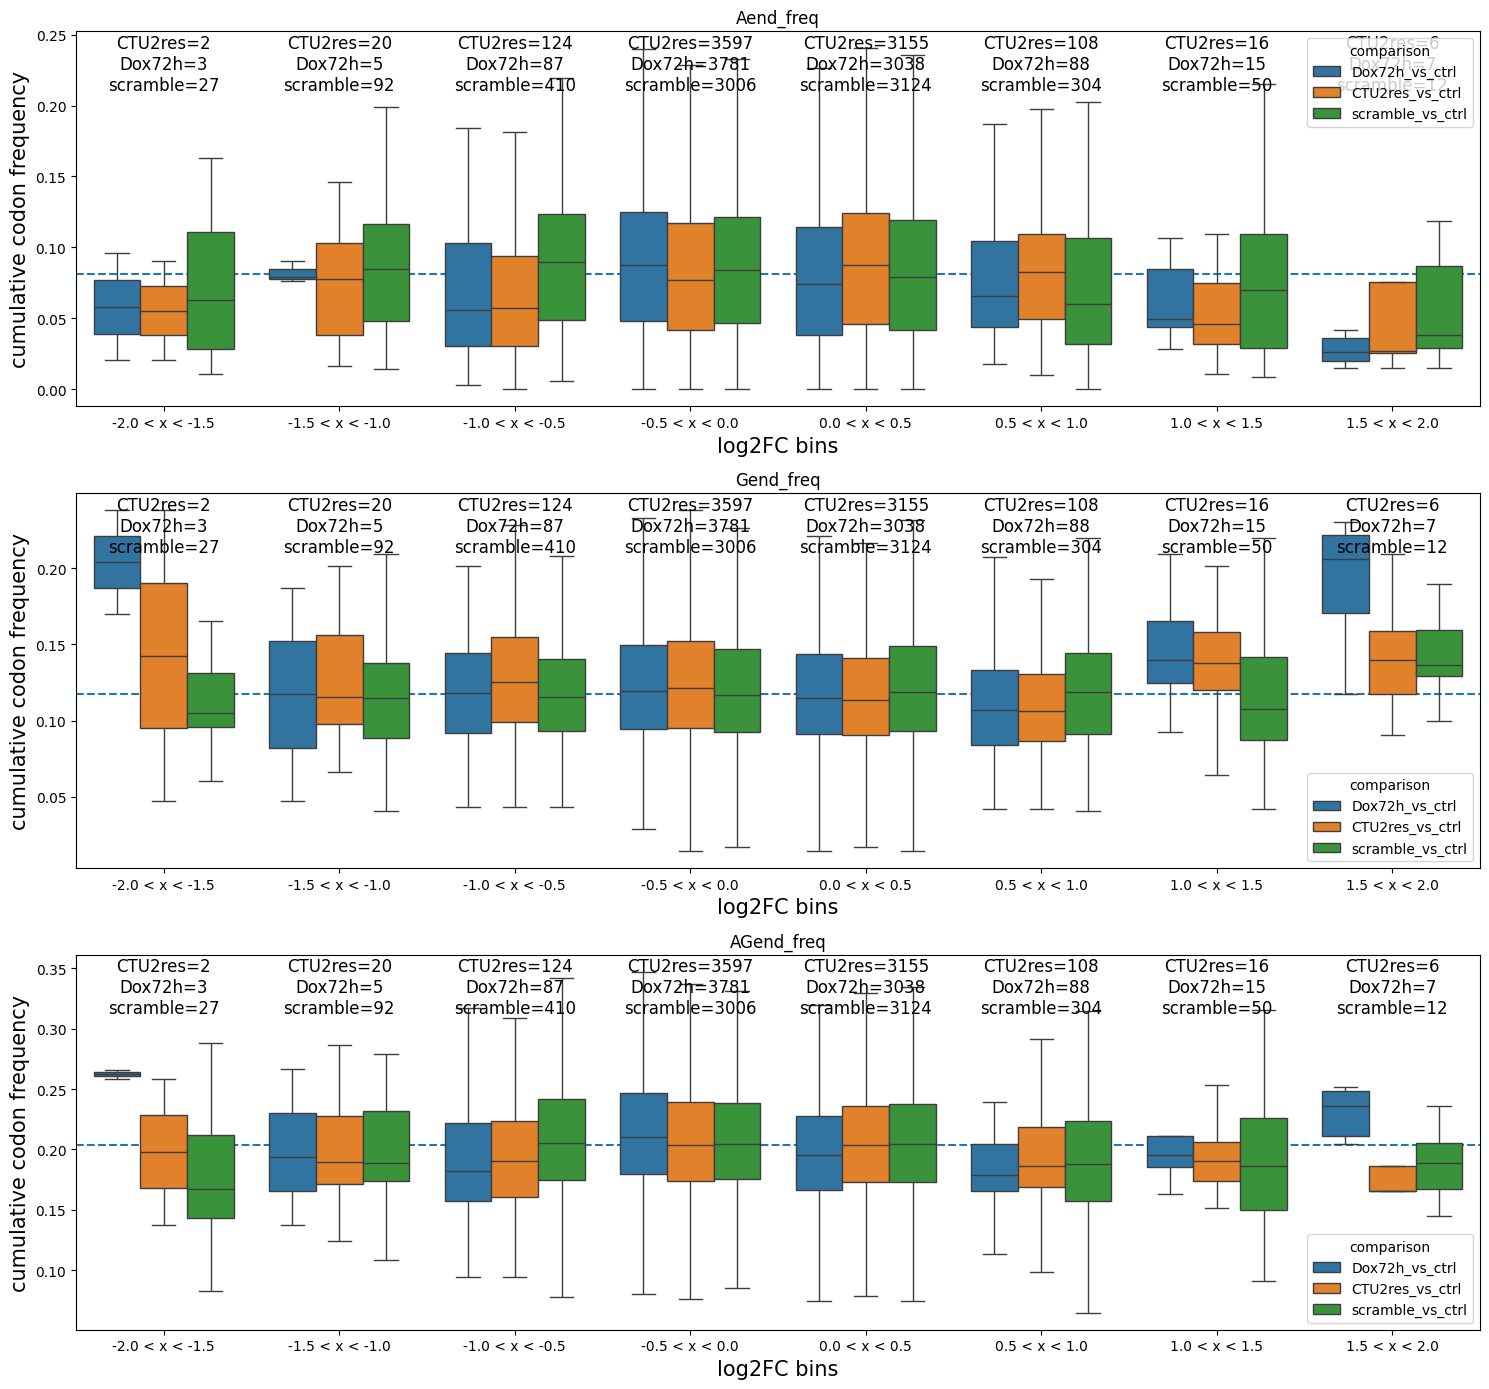

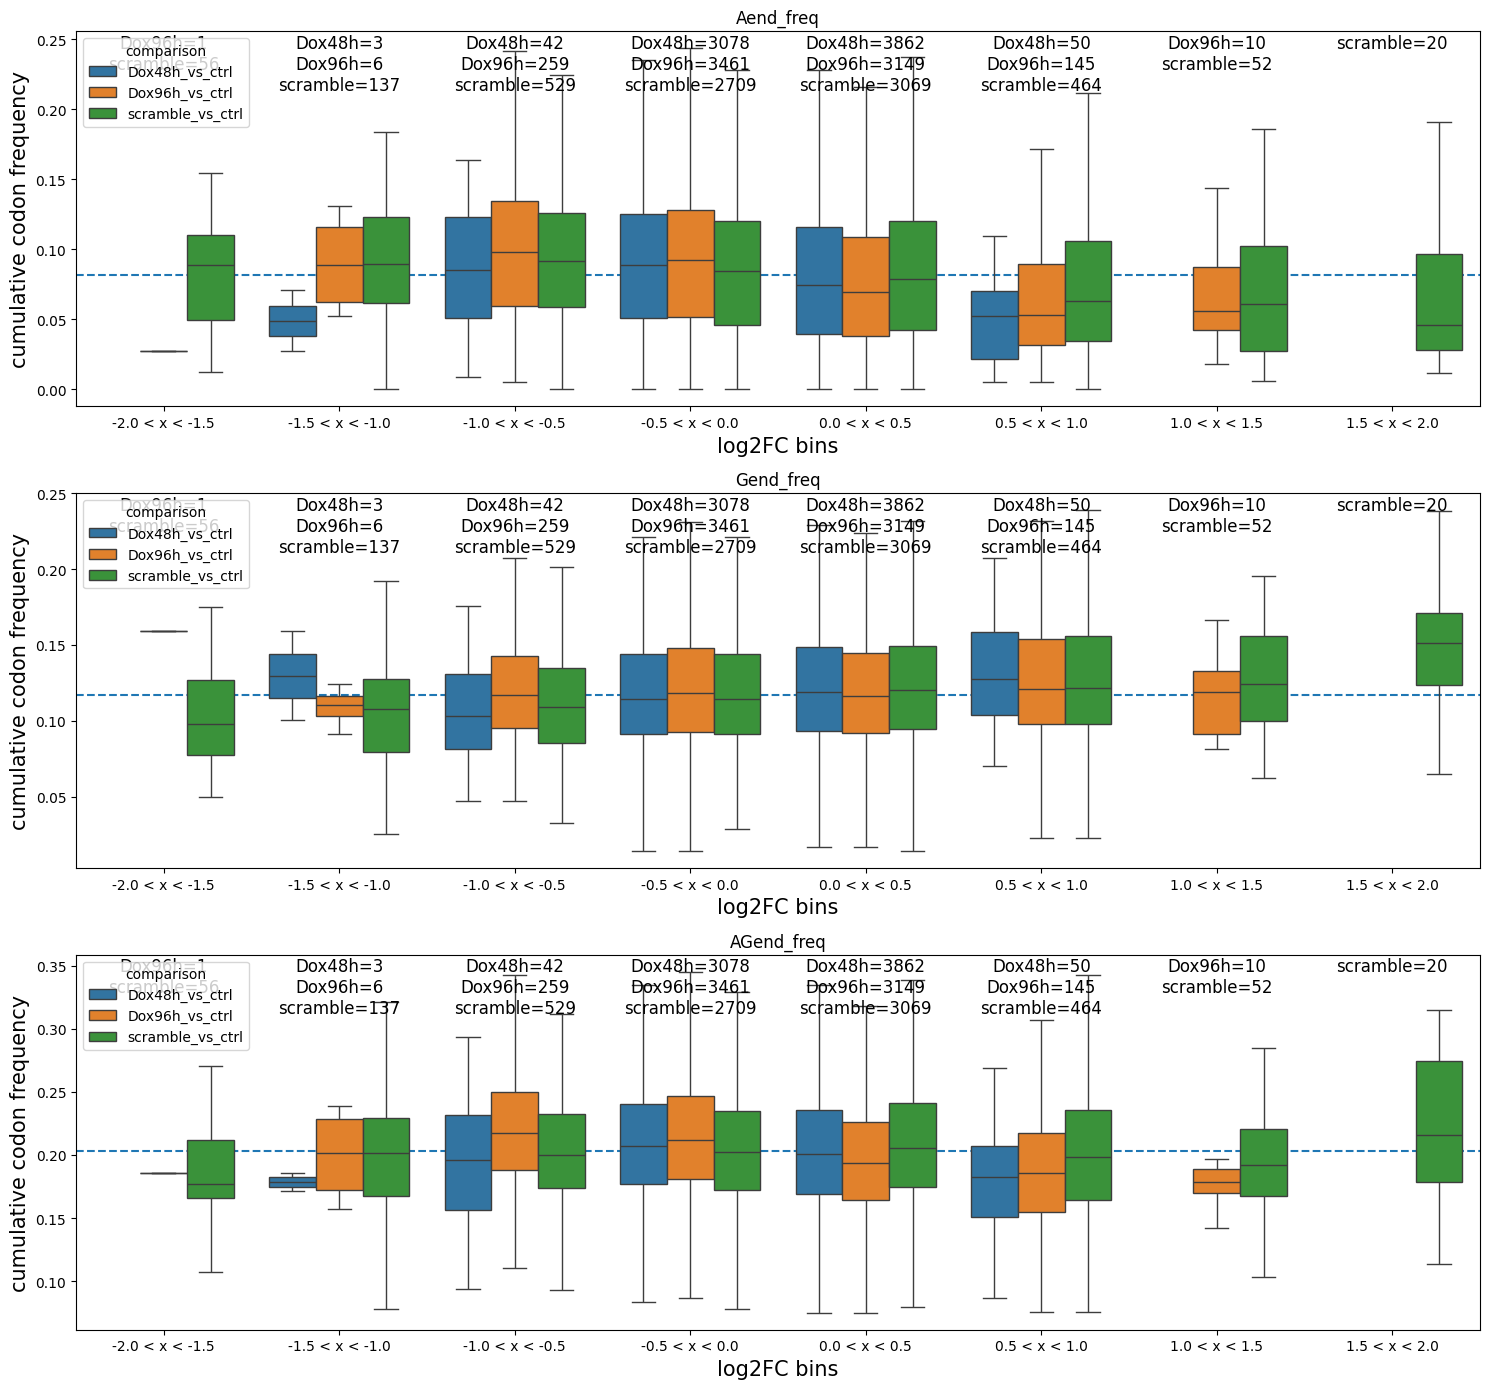

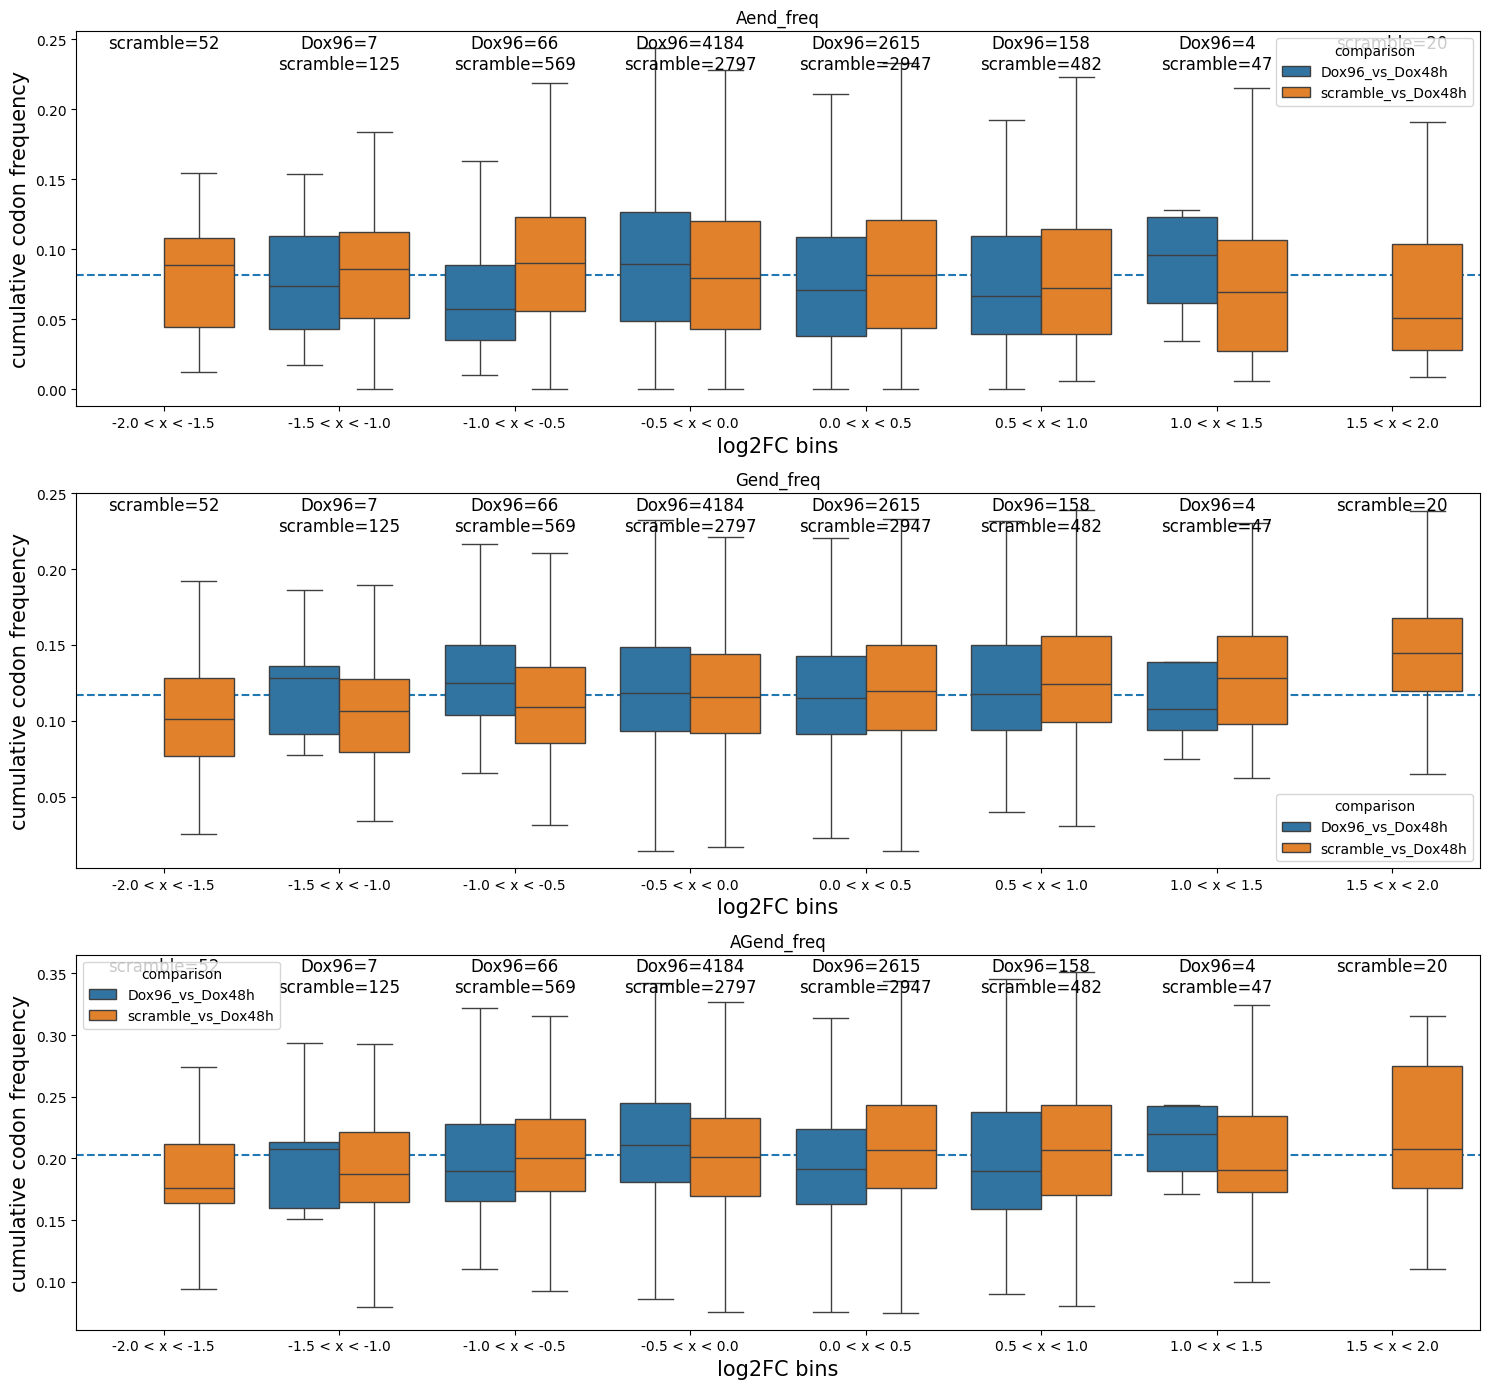

In [14]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import seaborn as sns


def melt(df, value_vars, value_name, rm_suffix = None):
    melted = df.reset_index().melt(
        id_vars = ['protein_ids', 'symbol'],
        value_vars = value_vars,
        value_name = value_name,
        var_name = 'comparison',
    )
    if rm_suffix:
        melted.loc[:, 'comparison'] = melted.comparison.str.replace(rm_suffix, '')
        
    return melted.set_index(['protein_ids', 'symbol', 'comparison'])


def melt_dataframe(df):
    pvals = melt(
        df, 
        df.columns[df.columns.str.endswith('(pval)')].to_list(), 
        '-log10(pval)', 
        ' -log(pval)'
    )
    lfcs = melt(        
        df, 
        df.columns[df.columns.str.endswith('diff')].to_list(), 
        'log2FC', 
        ' diff'
    )
    significance = melt(        
        df, 
        df.columns[df.columns.str.endswith('significant')].to_list(), 
        'significant', 
        ' significant'
    )
    combined = pd.concat(
        [pvals, lfcs],
        axis = 1
    )
    combined = combined.merge(
        significance,
        left_index = True,
        right_index = True,
        how = 'left'
    )
    merged = combined \
        .reset_index() \
        .merge(
            df.loc[:, df.columns.str.endswith('freq')].reset_index(),
            on = 'protein_ids',
            how = 'left'
        )
    
    return merged


def add_outliers_to_hilo(df, lo, hi):
    outliers = df[df.bins.isna()]
    lo_cat = df.bins.cat.categories[0]
    hi_cat = df.bins.cat.categories[-1]
    for i, outlier in outliers.iterrows():
        df.loc[i, 'bins'] = lo_cat if outlier.log2FC < lo else hi_cat

        
# cmap = LinearSegmentedColormap.from_list(
#     'cmap', 
#     [(190/255, 227/255, 239/255), (199/255, 49/255, 136/255)], 
#     N = 256
# )

coi_cols = ['Aend_freq', 'Gend_freq', 'AGend_freq']
for key, data in data_with_coifreqs.items():
    fig, axs = plt.subplots(len(coi_cols))
    df = melt_dataframe(data)
    df.dropna(subset = 'log2FC', inplace = True)
    bins = np.linspace(-2, 2, 9)
    labels = [
        f'{bins[i]} < x < {bins[i+1]}' for i in range(len(bins) - 1)
    ]
    
    # palette = {
    #     label: cmap(i/len(labels)) 
    #     for i, label 
    #     in enumerate(labels)
    # }
    
    df['bins'] = pd.cut(
        df.log2FC,
        bins = bins,
        labels = labels
    )
    add_outliers_to_hilo(df, -2, 2)
    for ax, coi_col in zip(axs, coi_cols):
        ax.set_title(coi_col)
        ax.axhline(
            df[coi_col].median(),
            ls = '--'
        )
        sns.boxplot(
            data = df,
            x = 'bins',
            y = coi_col,
            hue = 'comparison',
            showfliers = False,
            ax = ax
        )

        for i, (bin_, g1) in enumerate(df.groupby('bins')):
            tokens = []
            for comp, g2 in g1.groupby('comparison'):
                tokens.append(
                    comp.split('_')[0] + f'={len(g2)}'
                )
            
            ax.text(
                i, ax.get_ylim()[1] - 0.002,
                '\n'.join(tokens),
                va = 'top',
                ha = 'center',
                fontsize = 12
            )

        ax.tick_params(axis = 'x', labelsize = 10)
        ax.set_xlabel('log2FC bins', fontdict={'fontsize': 15})

        ax.tick_params(axis = 'y', labelsize = 10)
        ax.set_ylabel('cumulative codon frequency', fontdict={'fontsize': 15})

    fig.set_figwidth(15)
    fig.set_figheight(14)
    fig.tight_layout()
    fig.savefig(f'../plots/codon_freqency_{key}.pdf')

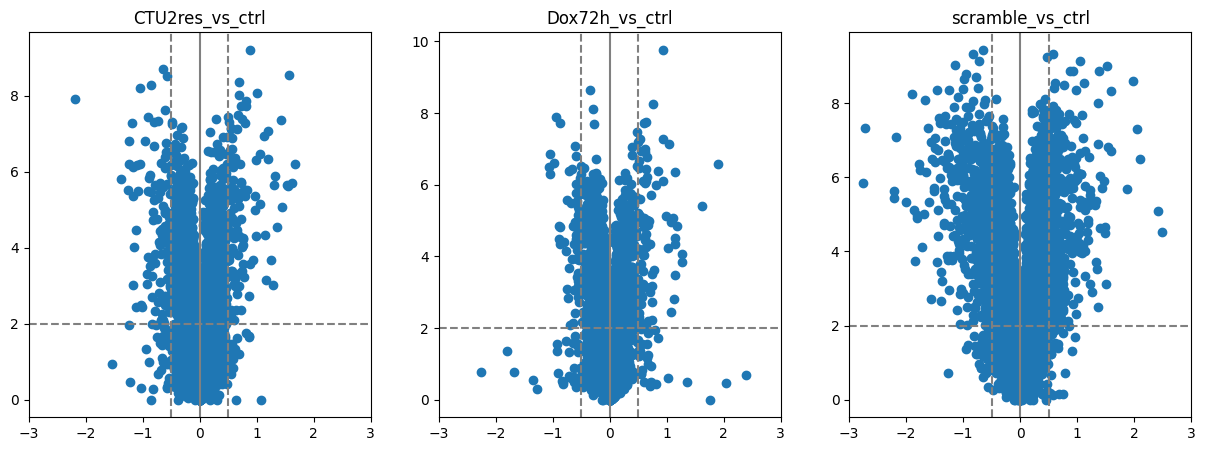

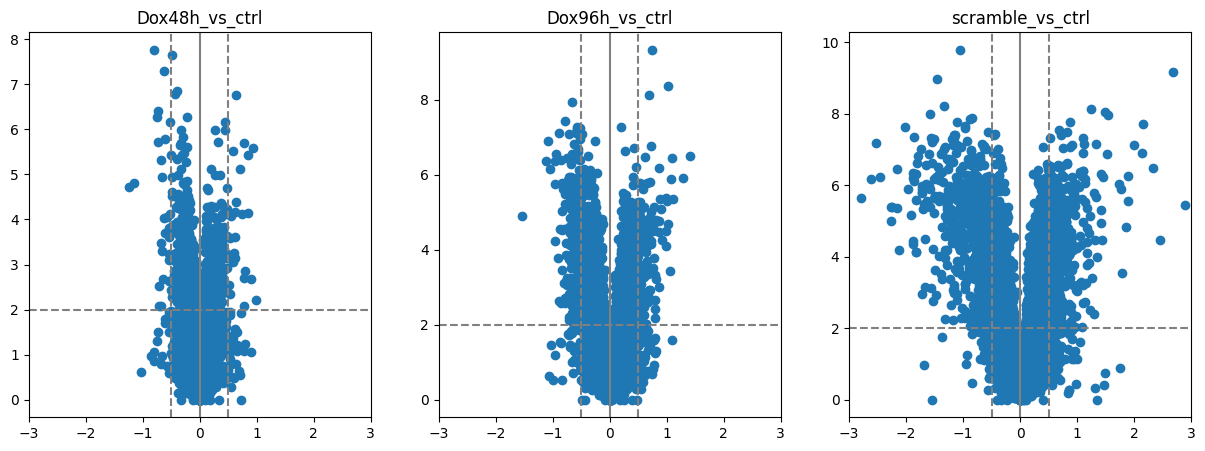

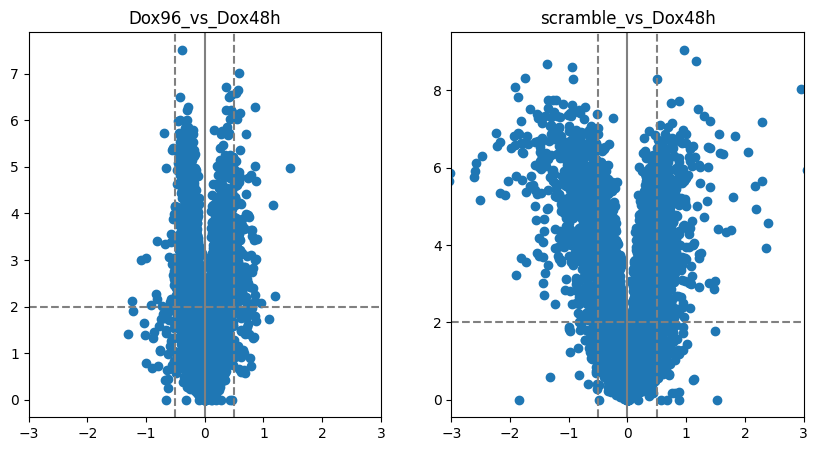

In [15]:
import numpy as np 


lfc = 0.5
pval = -np.log10(0.01)
for key, data in data_with_coifreqs.items():
    df = melt_dataframe(data)
    comparisons = df.comparison.unique()
    fig, axs = plt.subplots(1, len(comparisons))
    for ax, (comp, group) in zip(axs, df.groupby('comparison')):
        ax.scatter(
            group.log2FC,
            group['-log10(pval)']
        )
        ax.set_title(comp)
        ax.axvline(-lfc, ls = '--', c = 'grey')
        ax.axvline(lfc, ls = '--', c = 'grey')
        ax.axhline(pval, ls = '--', c = 'grey')
        ax.axvline(0, c = 'grey')
        max_abs_lfc = group.log2FC.abs().max() + 0.5
        ax.set_xlim(-3, 3)
        
    fig.set_figwidth(5 * len(comparisons))
    fig.set_figheight(5)

/var/folders/9x/qb03zwwn1q712g85g7vs_kjc0000gn/T/ipykernel_55847/439326370.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (bin_, g1) in enumerate(df.groupby('bins')):
/var/folders/9x/qb03zwwn1q712g85g7vs_kjc0000gn/T/ipykernel_55847/439326370.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (bin_, g1) in enumerate(df.groupby('bins')):
/var/folders/9x/qb03zwwn1q712g85g7vs_kjc0000gn/T/ipykernel_55847/439326370.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observ

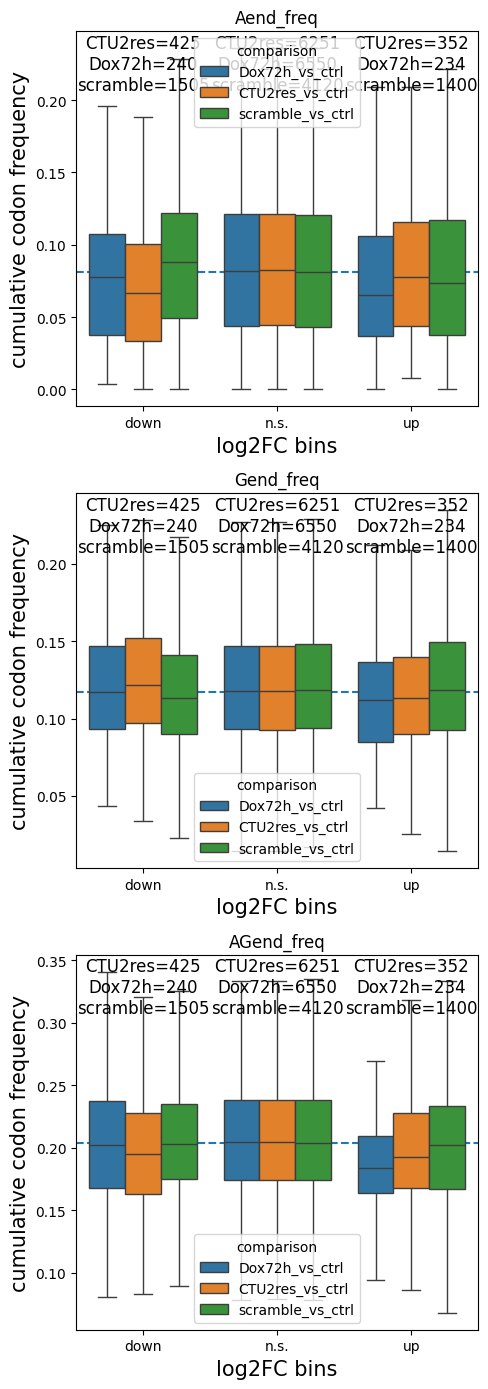

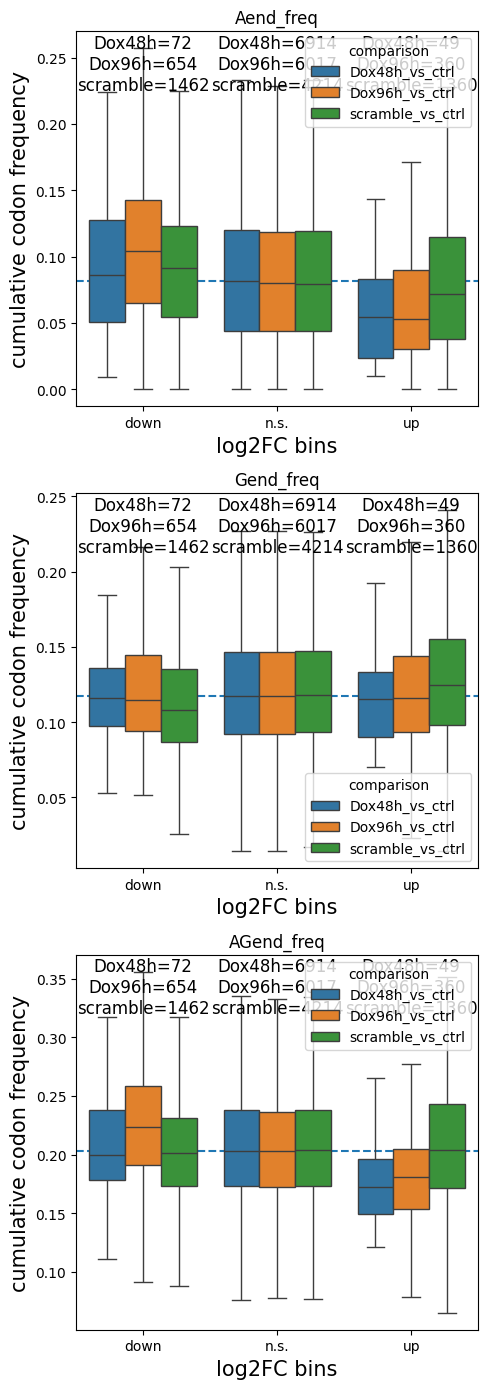

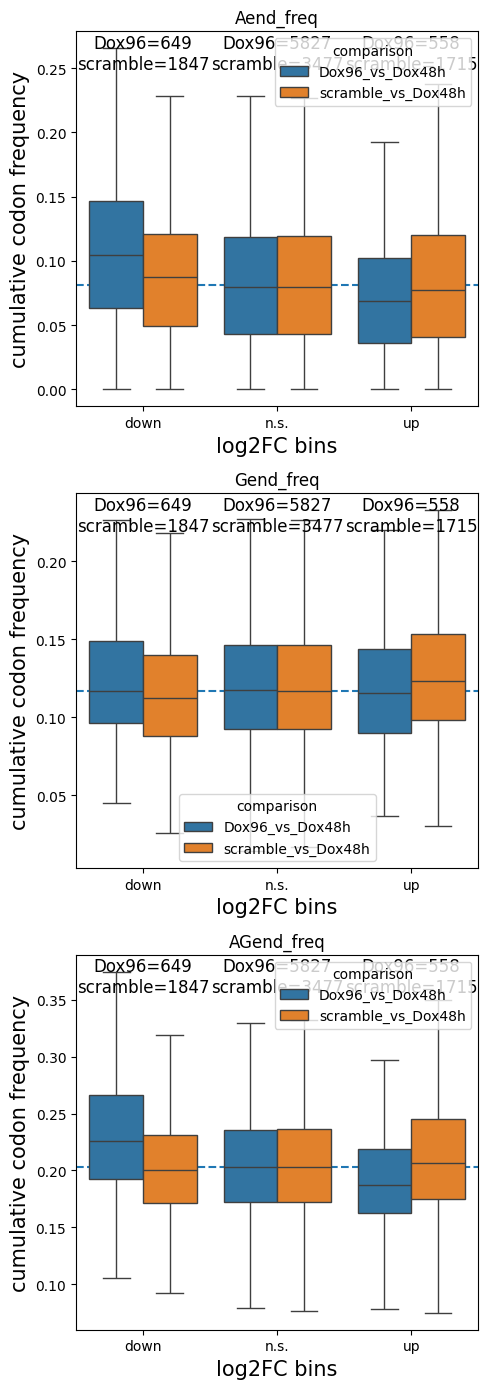

In [16]:
coi_cols = ['Aend_freq', 'Gend_freq', 'AGend_freq']
for key, data in data_with_coifreqs.items():
    fig, axs = plt.subplots(len(coi_cols))
    df = melt_dataframe(data)
    df.dropna(subset = 'log2FC', inplace = True)
    df['bins'] = 'n.s.'
    signif_idx = ~df['significant'].isna()
    df.loc[signif_idx, 'bins'] = df.loc[signif_idx, 'log2FC'].apply(lambda x: 'up' if x > 0 else 'down')
    labels = ['down', 'n.s.', 'up']
    df['bins'] = pd.Categorical(
        df['bins'],
        labels,
        ordered = True
    )
    
    # palette = {
    #     label: cmap(i/len(labels)) 
    #     for i, label 
    #     in enumerate(labels)
    # }

    for ax, coi_col in zip(axs, coi_cols):
        ax.set_title(coi_col)
        ax.axhline(
            df[coi_col].median(),
            ls = '--'
        )
        sns.boxplot(
            data = df,
            x = 'bins',
            y = coi_col,
            hue = 'comparison',
            showfliers = False,
            ax = ax
        )

        for i, (bin_, g1) in enumerate(df.groupby('bins')):
            tokens = []
            for comp, g2 in g1.groupby('comparison'):
                tokens.append(
                    comp.split('_')[0] + f'={len(g2)}'
                )
            
            ax.text(
                i, ax.get_ylim()[1] - 0.002,
                '\n'.join(tokens),
                va = 'top',
                ha = 'center',
                fontsize = 12
            )

        ax.tick_params(axis = 'x', labelsize = 10)
        ax.set_xlabel('log2FC bins', fontdict={'fontsize': 15})

        ax.tick_params(axis = 'y', labelsize = 10)
        ax.set_ylabel('cumulative codon frequency', fontdict={'fontsize': 15})

    fig.set_figwidth(5)
    fig.set_figheight(14)
    fig.tight_layout()
    fig.savefig(f'../plots/codon_frequency_{key}_signif.pdf')

/var/folders/9x/qb03zwwn1q712g85g7vs_kjc0000gn/T/ipykernel_55847/2426514789.py:107: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (bin_, g1) in enumerate(subdf.groupby('bins')):
/var/folders/9x/qb03zwwn1q712g85g7vs_kjc0000gn/T/ipykernel_55847/2426514789.py:107: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (bin_, g1) in enumerate(subdf.groupby('bins')):
/var/folders/9x/qb03zwwn1q712g85g7vs_kjc0000gn/T/ipykernel_55847/2426514789.py:107: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavi

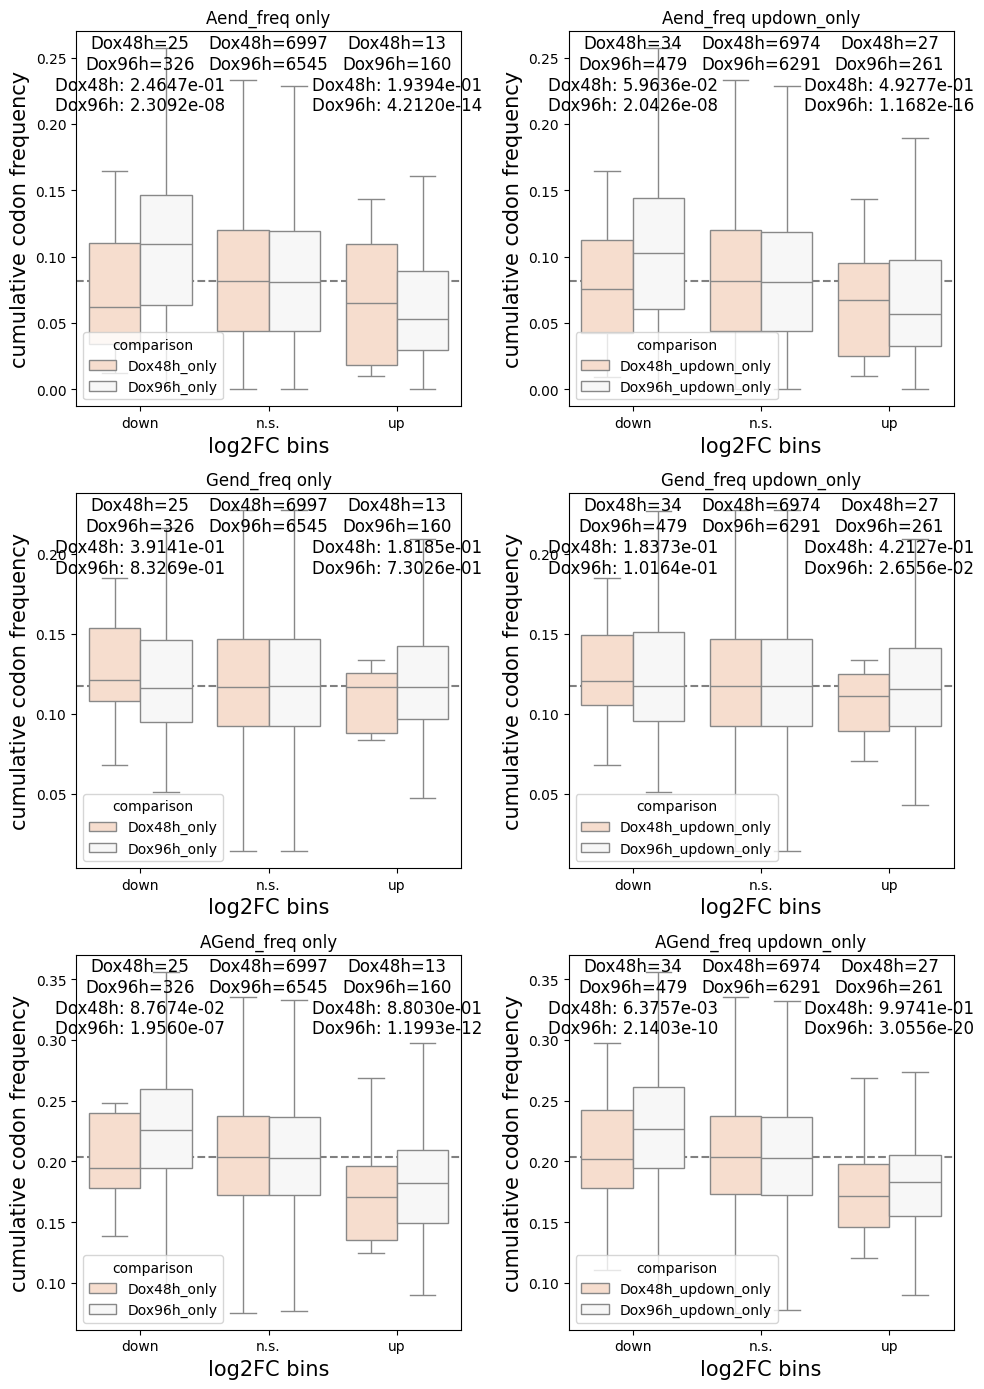

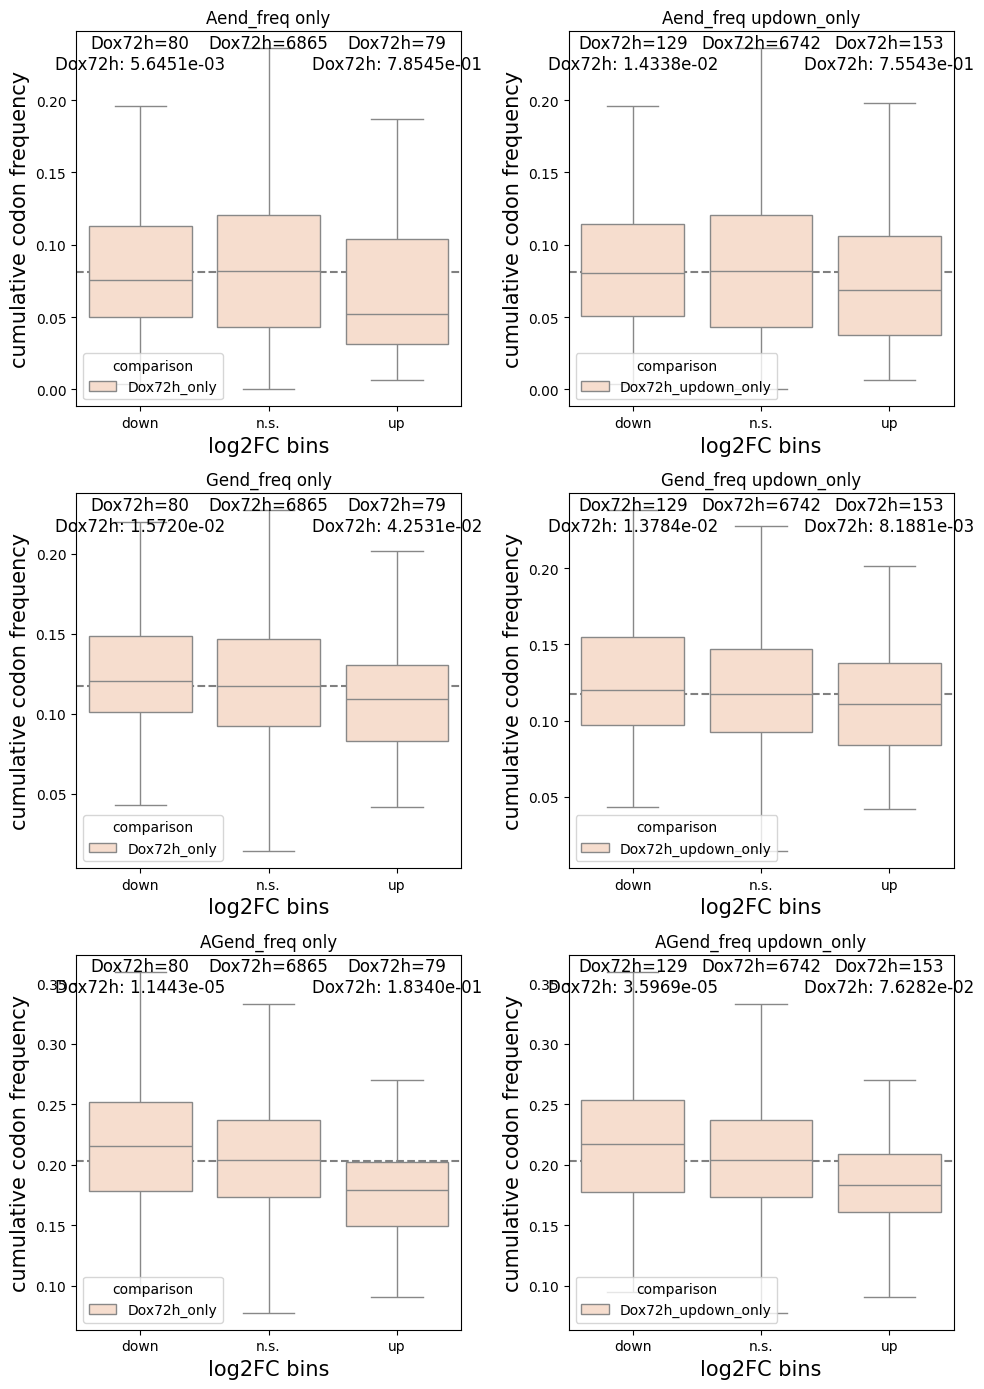

In [17]:
from scipy.stats import ttest_ind

coi_cols = ['Aend_freq', 'Gend_freq', 'AGend_freq']
no_scramble_coifreq = {
    k: data_with_coifreqs[k]
    for k
    in ['rpe1_ctrl', 'hela_ctrl']
}

def remove_comparison_suffix(df):
    df.loc[:, 'comparison'] = df.comparison.apply(
        lambda x: x.split('_')[0]
    )

    
def add_comparison_suffix(df, suffix):
    df.loc[:, 'comparison'] = df.comparison.apply(
        lambda x: x + f'_{suffix}'
    )
    
for key, data in no_scramble_coifreq.items():
    fig, axs = plt.subplots(len(coi_cols), 2) 
    df = melt_dataframe(data).drop(columns = 'significant')
    dox_only_data = df.loc[
        df.comparison.str.startswith('Dox'),
        :
    ]
    remove_comparison_suffix(dox_only_data)
    no_scramble = melt(
        data,
        data.columns[data.columns.str.endswith('significant')].to_list(), 
        'significant', 
        ' significant'
    ).reset_index()
    no_scramble_significant = no_scramble.loc[
        no_scramble.comparison.str.endswith('h_only'),
        :
    ]
    remove_comparison_suffix(no_scramble_significant)
    no_scramble_significant = no_scramble_significant.merge(
        dox_only_data,
        on = ['protein_ids', 'symbol', 'comparison'], 
        how = 'left'
    )
    add_comparison_suffix(no_scramble_significant, 'only')
    
    no_scramble_significant_updown = no_scramble.loc[
        no_scramble.comparison.str.endswith('updown_only'),
        :
    ]
    remove_comparison_suffix(no_scramble_significant_updown)
    no_scramble_significant_updown = no_scramble_significant_updown.merge(
        dox_only_data,
        on = ['protein_ids', 'symbol', 'comparison'], 
        how = 'left'
    )
    add_comparison_suffix(no_scramble_significant_updown, 'updown_only')
    

    df = pd.concat(
        [
            no_scramble_significant, 
            no_scramble_significant_updown
        ],
        ignore_index = True
    )
    df.dropna(subset = 'log2FC', inplace = True)
    df['bins'] = 'n.s.'
    signif_idx = ~df['significant'].isna()
    df.loc[signif_idx, 'bins'] = df.loc[signif_idx, 'log2FC'].apply(lambda x: 'up' if x > 0 else 'down')
    labels = ['down', 'n.s.', 'up']
    df['bins'] = pd.Categorical(
        df['bins'],
        labels,
        ordered = True
    )
    df['scramble_rm_type'] = df.comparison.apply(
        lambda x: '_'.join(x.split('_')[1:])
    )
    
    df[(df.scramble_rm_type == 'updown_only')].to_csv(
        f'../data/{key}_no_scramble_updown_only.tsv',
        sep = '\t'
    )
    
    for rowaxs, coi_col in zip(axs, coi_cols):
        for ax, (g, subdf) in zip(rowaxs, df.groupby('scramble_rm_type')):
            ax.set_title(coi_col + ' ' + g)
            ax.axhline(
                df[coi_col].median(),
                ls = '--',
                c = 'grey'
            )
            sns.boxplot(
                data = subdf,
                x = 'bins',
                y = coi_col,
                hue = 'comparison',
                showfliers = False,
                ax = ax,
                palette = ['#fddbc7', '#F7F7F7'],
                # medianprops={"color": "white", "linewidth": 1}
            )
            legend = ax.get_legend()
            legend.set_loc('lower left')

            for i, (bin_, g1) in enumerate(subdf.groupby('bins')):
                tokens = []
                for comp, g2 in g1.groupby('comparison'):
                    tokens.append(
                        comp.split('_')[0] + f'={len(g2)}'
                    )

                ax.text(
                    i, ax.get_ylim()[1] - 0.002,
                    '\n'.join(tokens),
                    va = 'top',
                    ha = 'center',
                    fontsize = 12
                )

            ax.tick_params(axis = 'x', labelsize = 10)
            ax.set_xlabel('log2FC bins', fontdict={'fontsize': 15})

            ax.tick_params(axis = 'y', labelsize = 10)
            ax.set_ylabel('cumulative codon frequency', fontdict={'fontsize': 15})
            
            for j, (comp, comp_data) in enumerate(subdf.groupby('comparison')):
                ctrl_values = comp_data.loc[comp_data.bins == 'n.s.', coi_col]
                for i, group in [(0, 'up'), (2, 'down')]:
                    values = comp_data.loc[comp_data.bins == group, coi_col]
                    res = ttest_ind(values, ctrl_values,  nan_policy = 'omit')
                    ax.text(
                        i, ax.get_ylim()[1] - 0.002,
                        '\n'.join([''] * (len(tokens) + j) + ['{}: {:.4e}'.format(comp.split('_')[0], res.pvalue)]),
                        va = 'top',
                        ha = 'center',
                        fontsize = 12
                    )
                    
                
    fig.set_figwidth(10)
    fig.set_figheight(14)
    fig.tight_layout()
    fig.savefig(f'../plots/codon_frequency_{key}_signif_wo_scramble.pdf')

In [18]:
no_scramble.comparison.unique()

array(['Dox72h_vs_ctrl', 'CTU2res_vs_ctrl', 'scramble_vs_ctrl',
       'Dox72h_only', 'Dox72h_updown_only'], dtype=object)

In [19]:
import numpy as np

data_with_coienrichments = {}
for key, df in data_with_coifreqs.items():
    df = df.copy()
    for col in df.columns[df.columns.str.endswith('freq')]:
        df[col] = np.log2(df.loc[:, col] / df.loc[:, col].median())
    
    data_with_coienrichments[key] = df

/Users/dmalzl/miniconda3/envs/codons/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dmalzl/miniconda3/envs/codons/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/dmalzl/miniconda3/envs/codons/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


/var/folders/9x/qb03zwwn1q712g85g7vs_kjc0000gn/T/ipykernel_55847/3306271935.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (bin_, g1) in enumerate(df.groupby('bins')):
/var/folders/9x/qb03zwwn1q712g85g7vs_kjc0000gn/T/ipykernel_55847/3306271935.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (bin_, g1) in enumerate(df.groupby('bins')):
/var/folders/9x/qb03zwwn1q712g85g7vs_kjc0000gn/T/ipykernel_55847/3306271935.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obs

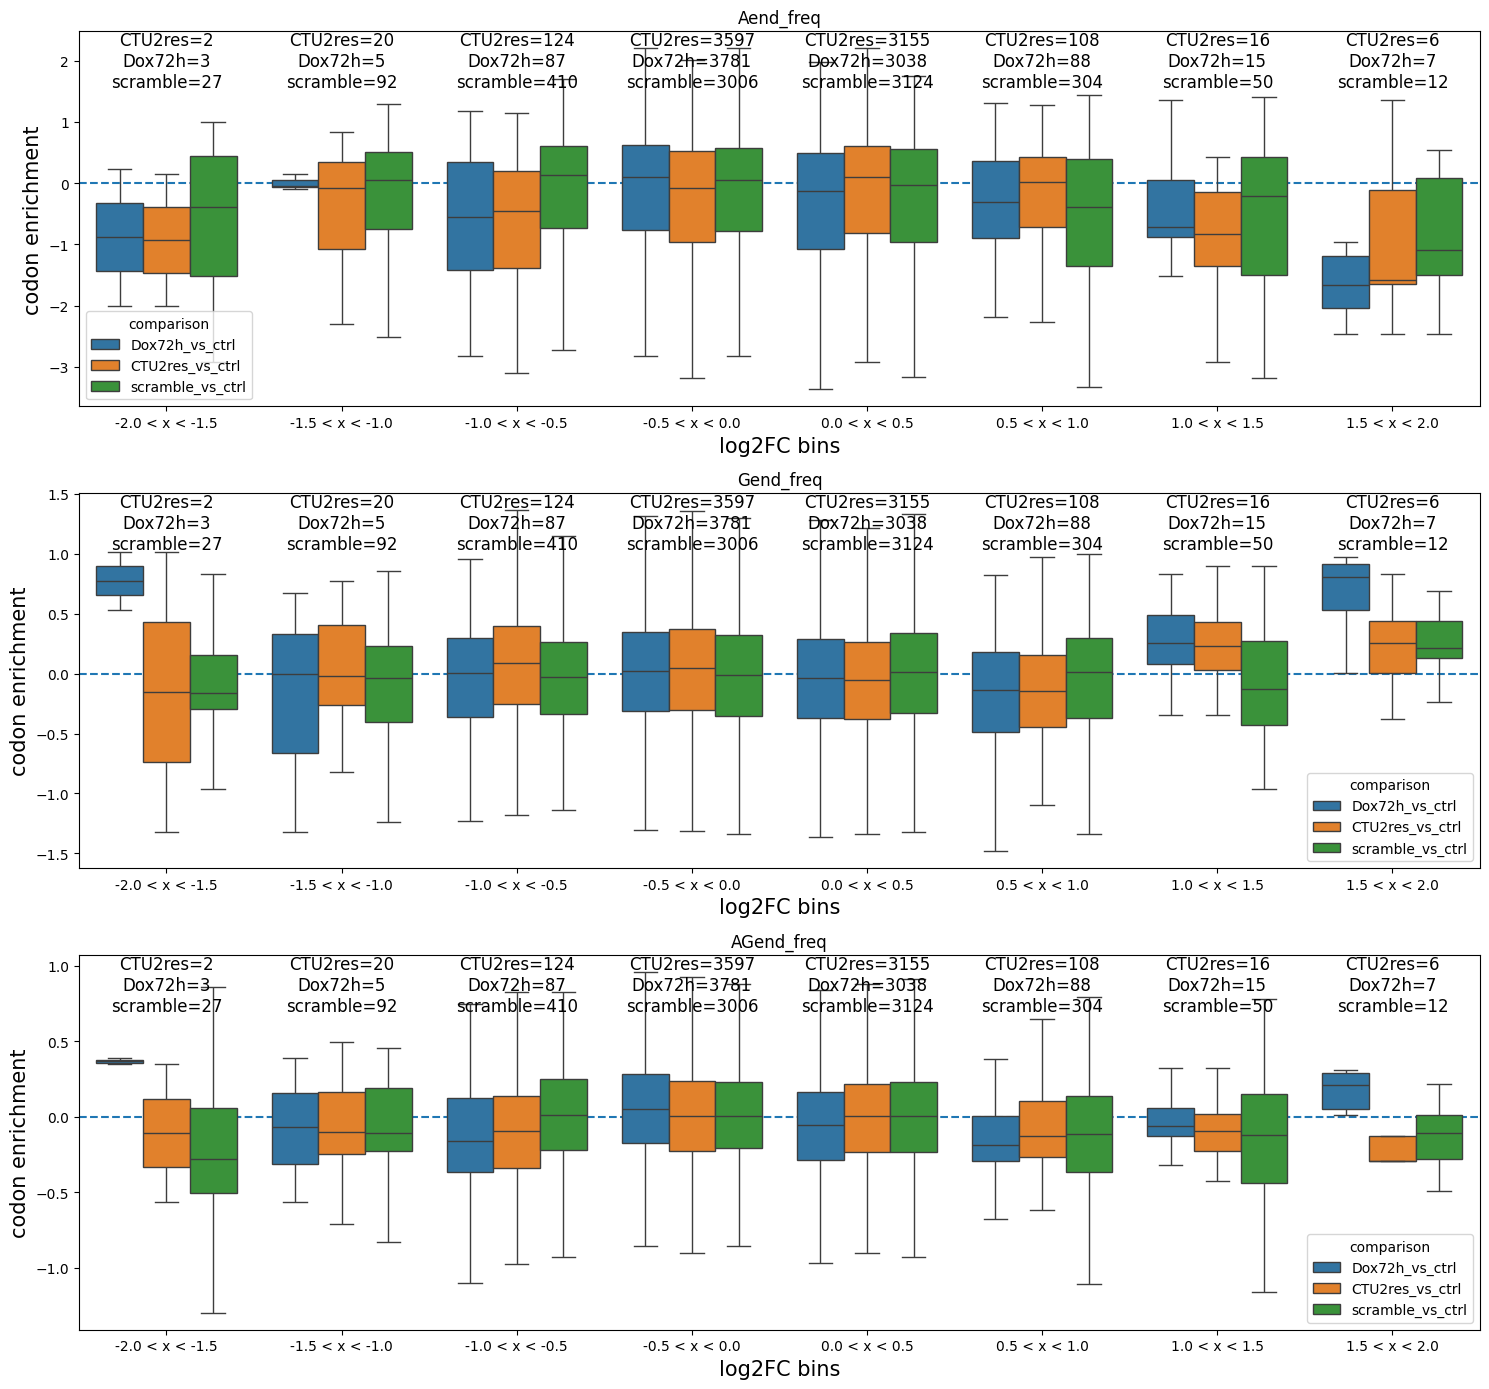

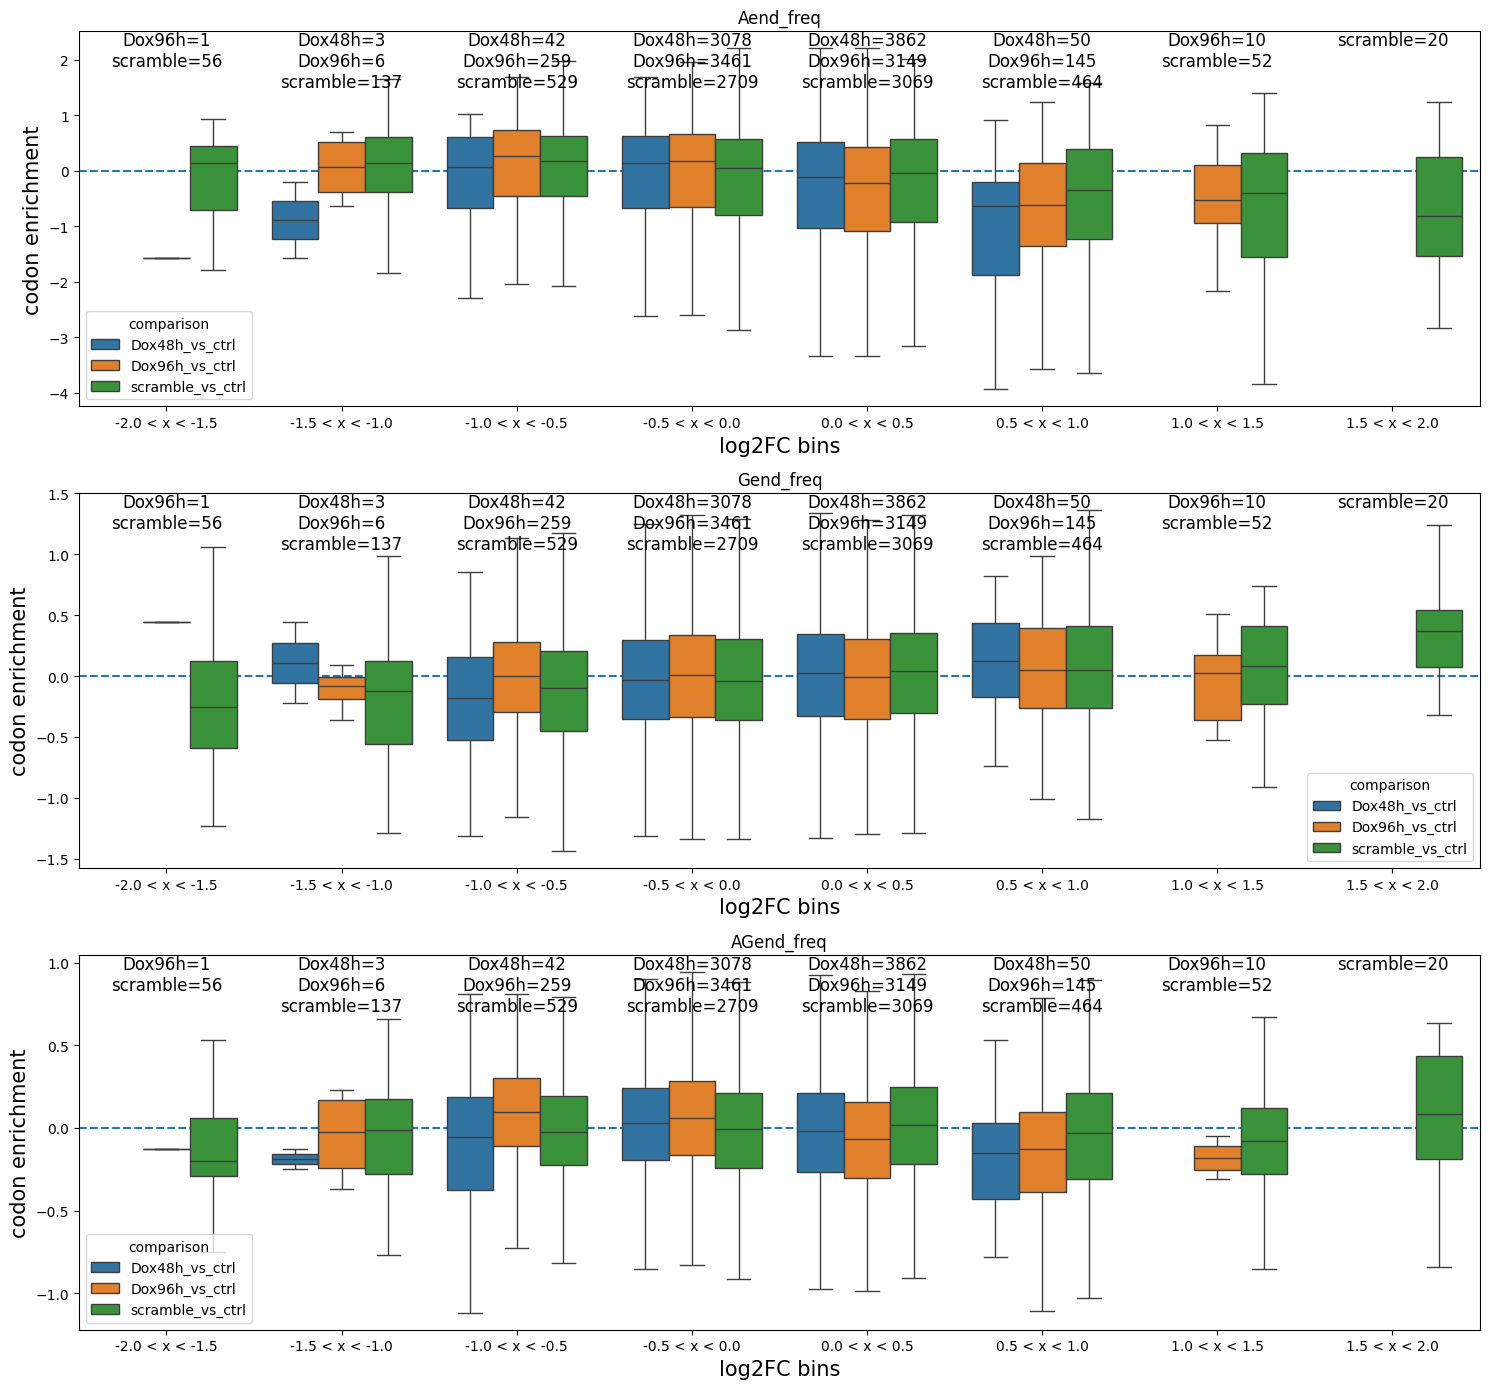

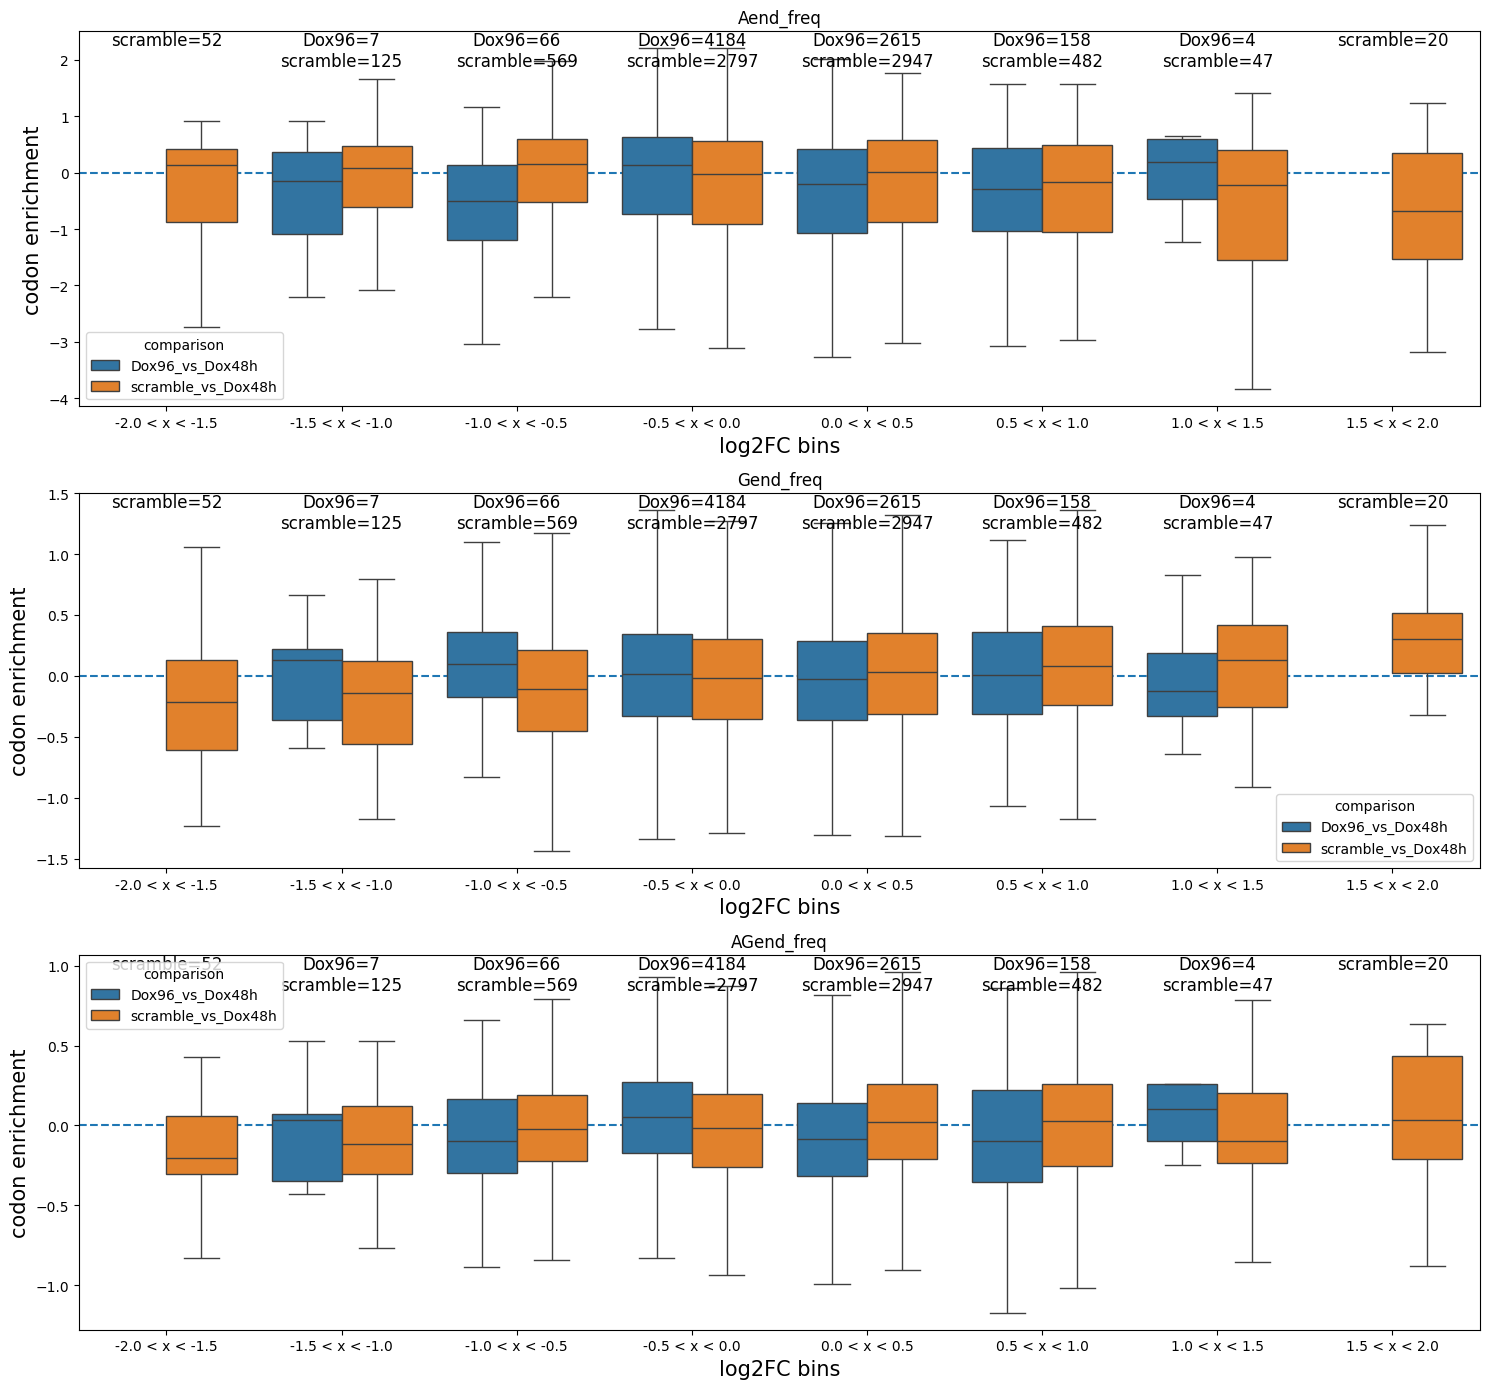

In [20]:
coi_cols = ['Aend_freq', 'Gend_freq', 'AGend_freq']
for key, data in data_with_coienrichments.items():
    fig, axs = plt.subplots(len(coi_cols))
    df = melt_dataframe(data)
    df.dropna(subset = 'log2FC', inplace = True)
    bins = np.linspace(-2, 2, 9)
    labels = [
        f'{bins[i]} < x < {bins[i+1]}' for i in range(len(bins) - 1)
    ]
    
    # palette = {
    #     label: cmap(i/len(labels)) 
    #     for i, label 
    #     in enumerate(labels)
    # }
    
    df['bins'] = pd.cut(
        df.log2FC,
        bins = bins,
        labels = labels
    )
    add_outliers_to_hilo(df, -2, 2)
    for ax, coi_col in zip(axs, coi_cols):
        ax.set_title(coi_col)
        ax.axhline(
            df[coi_col].median(),
            ls = '--'
        )
        sns.boxplot(
            data = df,
            x = 'bins',
            y = coi_col,
            hue = 'comparison',
            showfliers = False,
            ax = ax
        )

        for i, (bin_, g1) in enumerate(df.groupby('bins')):
            tokens = []
            for comp, g2 in g1.groupby('comparison'):
                tokens.append(
                    comp.split('_')[0] + f'={len(g2)}'
                )
            
            ax.text(
                i, ax.get_ylim()[1] - 0.002,
                '\n'.join(tokens),
                va = 'top',
                ha = 'center',
                fontsize = 12
            )

        ax.tick_params(axis = 'x', labelsize = 10)
        ax.set_xlabel('log2FC bins', fontdict={'fontsize': 15})

        ax.tick_params(axis = 'y', labelsize = 10)
        ax.set_ylabel('codon enrichment', fontdict={'fontsize': 15})

    fig.set_figwidth(15)
    fig.set_figheight(14)
    fig.tight_layout()
    fig.savefig(f'../plots/codon_enrichment_{key}.pdf')

/var/folders/9x/qb03zwwn1q712g85g7vs_kjc0000gn/T/ipykernel_55847/3914004331.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (bin_, g1) in enumerate(df.groupby('bins')):
/var/folders/9x/qb03zwwn1q712g85g7vs_kjc0000gn/T/ipykernel_55847/3914004331.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (bin_, g1) in enumerate(df.groupby('bins')):
/var/folders/9x/qb03zwwn1q712g85g7vs_kjc0000gn/T/ipykernel_55847/3914004331.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obs

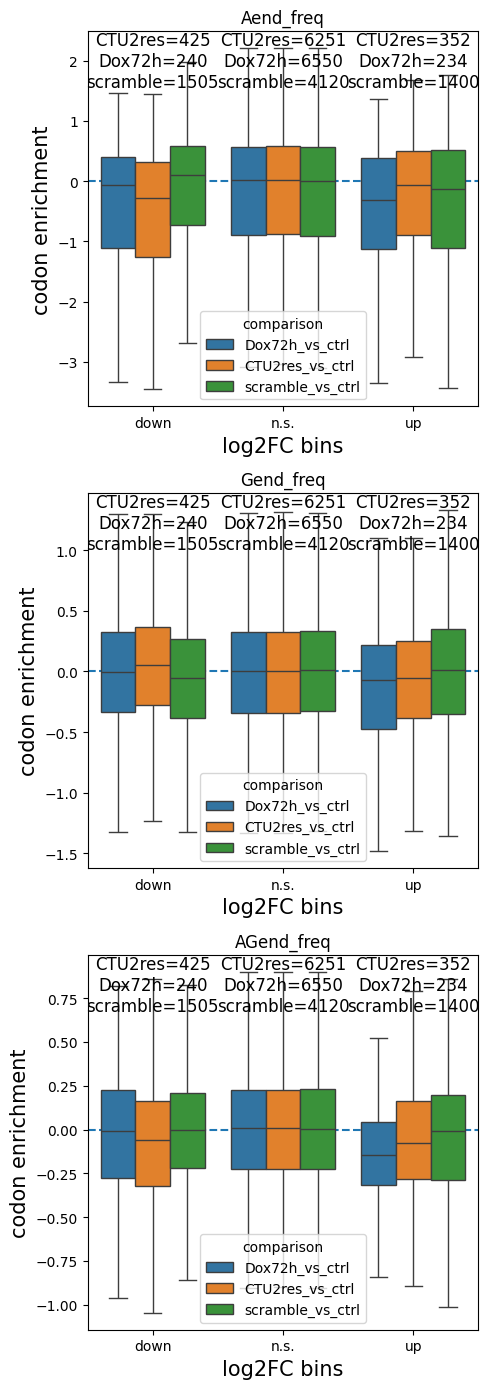

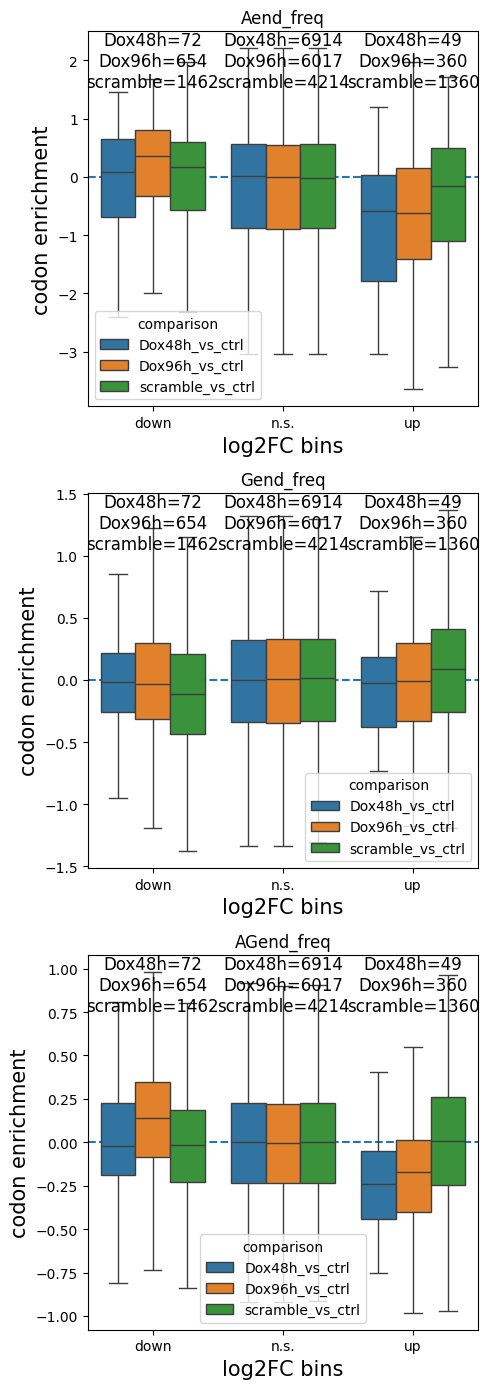

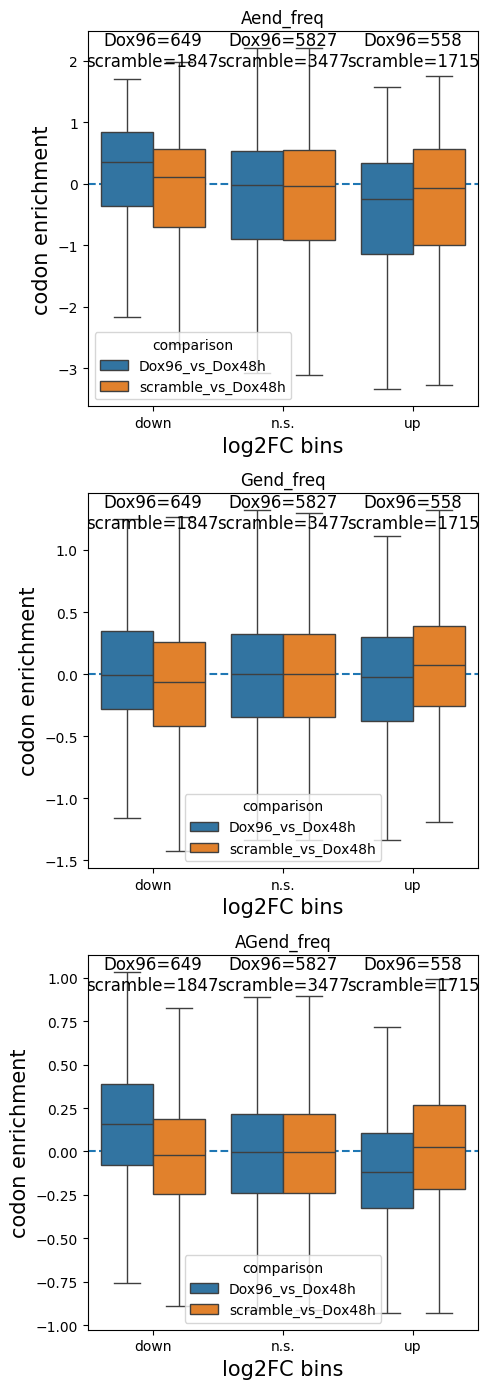

In [21]:
coi_cols = ['Aend_freq', 'Gend_freq', 'AGend_freq']
for key, data in data_with_coienrichments.items():
    fig, axs = plt.subplots(len(coi_cols))
    df = melt_dataframe(data)
    df.dropna(subset = 'log2FC', inplace = True)
    df['bins'] = 'n.s.'
    signif_idx = ~df['significant'].isna()
    df.loc[signif_idx, 'bins'] = df.loc[signif_idx, 'log2FC'].apply(lambda x: 'up' if x > 0 else 'down')
    bins = np.linspace(-2, 2, 9)
    labels = ['down', 'n.s.', 'up']
    df['bins'] = pd.Categorical(
        df['bins'],
        labels,
        ordered = True
    )
    
    # palette = {
    #     label: cmap(i/len(labels)) 
    #     for i, label 
    #     in enumerate(labels)
    # }

    for ax, coi_col in zip(axs, coi_cols):
        ax.set_title(coi_col)
        ax.axhline(
            df[coi_col].median(),
            ls = '--'
        )
        sns.boxplot(
            data = df,
            x = 'bins',
            y = coi_col,
            hue = 'comparison',
            showfliers = False,
            ax = ax
        )

        for i, (bin_, g1) in enumerate(df.groupby('bins')):
            tokens = []
            for comp, g2 in g1.groupby('comparison'):
                tokens.append(
                    comp.split('_')[0] + f'={len(g2)}'
                )
            
            ax.text(
                i, ax.get_ylim()[1] - 0.002,
                '\n'.join(tokens),
                va = 'top',
                ha = 'center',
                fontsize = 12
            )

        ax.tick_params(axis = 'x', labelsize = 10)
        ax.set_xlabel('log2FC bins', fontdict={'fontsize': 15})

        ax.tick_params(axis = 'y', labelsize = 10)
        ax.set_ylabel('codon enrichment', fontdict={'fontsize': 15})

    fig.set_figwidth(5)
    fig.set_figheight(14)
    fig.tight_layout()
    fig.savefig(f'../plots/codon_enrichment_{key}_signif.pdf')

/var/folders/9x/qb03zwwn1q712g85g7vs_kjc0000gn/T/ipykernel_55847/511598274.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (bin_, g1) in enumerate(df.groupby('bins')):
/var/folders/9x/qb03zwwn1q712g85g7vs_kjc0000gn/T/ipykernel_55847/511598274.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for i, (bin_, g1) in enumerate(df.groupby('bins')):
/var/folders/9x/qb03zwwn1q712g85g7vs_kjc0000gn/T/ipykernel_55847/511598274.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observ

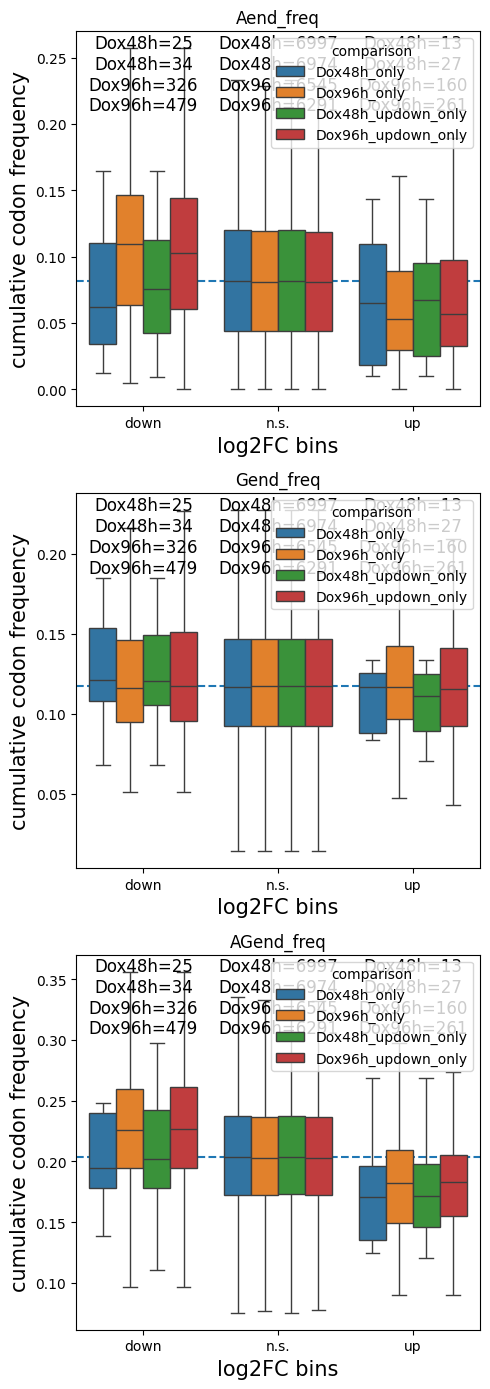

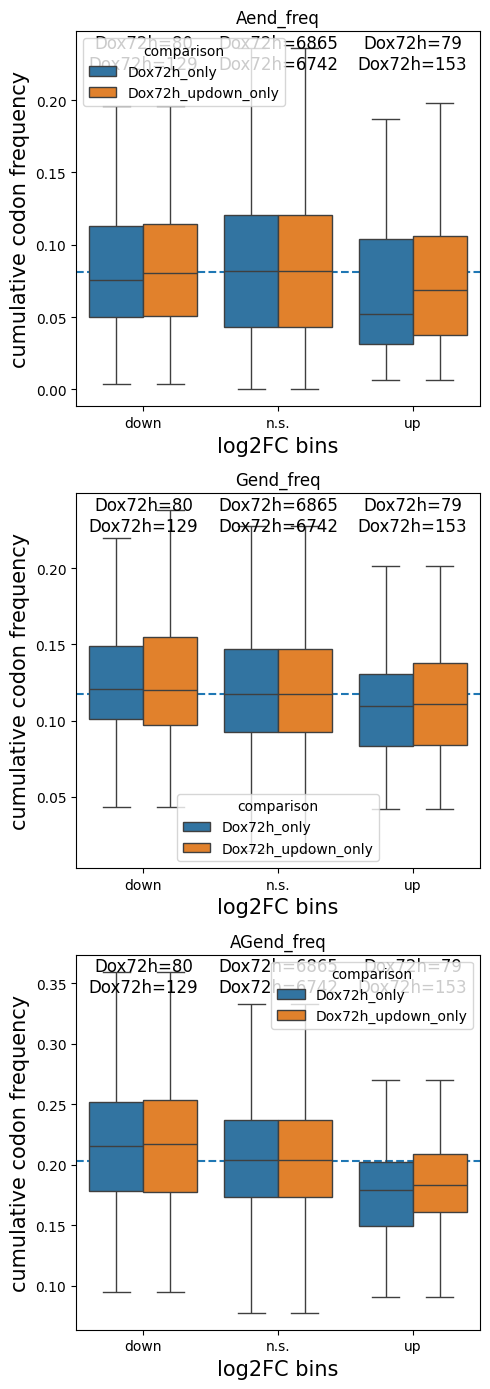

In [22]:
coi_cols = ['Aend_freq', 'Gend_freq', 'AGend_freq']
no_scramble_coienrich = {
    k: data_with_coifreqs[k]
    for k
    in ['rpe1_ctrl', 'hela_ctrl']
}
    
for key, data in no_scramble_coienrich.items():
    fig, axs = plt.subplots(len(coi_cols)) 
    df = melt_dataframe(data).drop(columns = 'significant')
    dox_only_data = df.loc[
        df.comparison.str.startswith('Dox'),
        :
    ]
    remove_comparison_suffix(dox_only_data)
    no_scramble = melt(
        data,
        data.columns[data.columns.str.endswith('significant')].to_list(), 
        'significant', 
        ' significant'
    ).reset_index()
    no_scramble_significant = no_scramble.loc[
        no_scramble.comparison.str.endswith('h_only'),
        :
    ]
    remove_comparison_suffix(no_scramble_significant)
    no_scramble_significant = no_scramble_significant.merge(
        dox_only_data,
        on = ['protein_ids', 'symbol', 'comparison'], 
        how = 'left'
    )
    add_comparison_suffix(no_scramble_significant, 'only')
    
    no_scramble_significant_updown = no_scramble.loc[
        no_scramble.comparison.str.endswith('updown_only'),
        :
    ]
    remove_comparison_suffix(no_scramble_significant_updown)
    no_scramble_significant_updown = no_scramble_significant_updown.merge(
        dox_only_data,
        on = ['protein_ids', 'symbol', 'comparison'], 
        how = 'left'
    )
    add_comparison_suffix(no_scramble_significant_updown, 'updown_only')
    
    df = pd.concat(
        [
            no_scramble_significant, 
            no_scramble_significant_updown
        ],
        ignore_index = True
    )
    df.dropna(subset = 'log2FC', inplace = True)
    df['bins'] = 'n.s.'
    signif_idx = ~df['significant'].isna()
    df.loc[signif_idx, 'bins'] = df.loc[signif_idx, 'log2FC'].apply(lambda x: 'up' if x > 0 else 'down')
    labels = ['down', 'n.s.', 'up']
    df['bins'] = pd.Categorical(
        df['bins'],
        labels,
        ordered = True
    )
    
    # palette = {
    #     label: cmap(i/len(labels)) 
    #     for i, label 
    #     in enumerate(labels)
    # }

    for ax, coi_col in zip(axs, coi_cols):
        ax.set_title(coi_col)
        ax.axhline(
            df[coi_col].median(),
            ls = '--'
        )
        sns.boxplot(
            data = df,
            x = 'bins',
            y = coi_col,
            hue = 'comparison',
            showfliers = False,
            ax = ax
        )

        for i, (bin_, g1) in enumerate(df.groupby('bins')):
            tokens = []
            for comp, g2 in g1.groupby('comparison'):
                tokens.append(
                    comp.split('_')[0] + f'={len(g2)}'
                )
            
            ax.text(
                i, ax.get_ylim()[1] - 0.002,
                '\n'.join(tokens),
                va = 'top',
                ha = 'center',
                fontsize = 12
            )

        ax.tick_params(axis = 'x', labelsize = 10)
        ax.set_xlabel('log2FC bins', fontdict={'fontsize': 15})

        ax.tick_params(axis = 'y', labelsize = 10)
        ax.set_ylabel('cumulative codon frequency', fontdict={'fontsize': 15})

    fig.set_figwidth(5)
    fig.set_figheight(14)
    fig.tight_layout()
    fig.savefig(f'../plots/codon_enrichment_{key}_signif_wo_scramble.pdf')

Dox48h_vs_ctrl -log(pval)  \
protein_ids                                                              
sp|P10809|CH60_HUMAN                                          0.174526   
sp|P13639|EF2_HUMAN                                           0.233879   
sp|Q6VY07|PACS1_HUMAN;sp|Q86VP3|PACS2_HUMAN                   0.624933   
sp|Q9NX62|IMPA3_HUMAN                                         0.806480   
sp|P18206|VINC_HUMAN                                          1.356438   
...                                                                ...   
sp|P53803|RPAB4_HUMAN                                         0.602852   
sp|Q9P215|POGK_HUMAN                                          0.550658   
sp|Q969K4|ABTB1_HUMAN                                         0.175075   
sp|Q7Z6M2|FBX33_HUMAN                                         0.431413   
sp|Q9NPE2|NGRN_HUMAN                                          0.459074   

                                             Dox48h_vs_ctrl diff  \
protein_ids                                                        
sp|P10809|CH60_HUMAN                                   -0.017739   
sp|P13639|EF2_HUMAN                                     0.030314   
sp|Q6VY07|PACS1_HUMAN;sp|Q86VP3|PACS2_HUMAN             0.051530   
sp|Q9NX62|IMPA3_HUMAN                                  -0.065230   
sp|P18206|VINC_HUMAN                                   -0.099390   
...                                                          ...   
sp|P53803|RPAB4_HUMAN                                  -0.126100   
sp|Q9P215|POGK_HUMAN                                    0.115272   
sp|Q969K4|ABTB1_HUMAN                                  -0.094258   
sp|Q7Z6M2|FBX33_HUMAN                                   0.099608   
sp|Q9NPE2|NGRN_HUMAN                                    0.094677   

                                            Dox48h_vs_ctrl significant  \
protein_ids                                                              
sp|P10809|CH60_HUMAN                                               NaN   
sp|P13639|EF2_HUMAN                                                NaN   
sp|Q6VY07|PACS1_HUMAN;sp|Q86VP3|PACS2_HUMAN                        NaN   
sp|Q9NX62|IMPA3_HUMAN                                              NaN   
sp|P18206|VINC_HUMAN                                               NaN   
...                                                                ...   
sp|P53803|RPAB4_HUMAN                                              NaN   
sp|Q9P215|POGK_HUMAN                                               NaN   
sp|Q969K4|ABTB1_HUMAN                                              NaN   
sp|Q7Z6M2|FBX33_HUMAN                                              NaN   
sp|Q9NPE2|NGRN_HUMAN                                               NaN   

                                             Dox96h_vs_ctrl -log(pval)  \
protein_ids                                                              
sp|P10809|CH60_HUMAN                                          0.502879   
sp|P13639|EF2_HUMAN                                           0.158223   
sp|Q6VY07|PACS1_HUMAN;sp|Q86VP3|PACS2_HUMAN                   0.403260   
sp|Q9NX62|IMPA3_HUMAN                                         2.350901   
sp|P18206|VINC_HUMAN                                          1.105078   
...                                                                ...   
sp|P53803|RPAB4_HUMAN                                         0.169527   
sp|Q9P215|POGK_HUMAN                                          0.289853   
sp|Q969K4|ABTB1_HUMAN                                         0.441543   
sp|Q7Z6M2|FBX33_HUMAN                                         2.457084   
sp|Q9NPE2|NGRN_HUMAN                                          0.137407   

                                             Dox96h_vs_ctrl diff  \
protein_ids                                                        
sp|P10809|CH60_HUMAN                                    0.040628   
sp|P13639|EF2_HUMAN                                     0.020981   

In [60]:
data = data_with_coifreqs['rpe1_ctrl']
df = melt_dataframe(data)
df.dropna(subset = 'log2FC', inplace = True)
df['bins'] = 'n.s.'
signif_idx = ~df['significant'].isna()
df.loc[signif_idx, 'bins'] = df.loc[signif_idx, 'log2FC'].apply(lambda x: 'up' if x > 0 else 'down')
labels = ['down', 'n.s.', 'up']
df['bins'] = pd.Categorical(
    df['bins'],
    labels,
    ordered = True
)
df = df.loc[df.comparison == 'Dox96h_vs_ctrl', :]
df

protein_ids       symbol  \
7047                          sp|P10809|CH60_HUMAN        HSPD1   
7048                           sp|P13639|EF2_HUMAN         EEF2   
7049   sp|Q6VY07|PACS1_HUMAN;sp|Q86VP3|PACS2_HUMAN  PACS1;PACS2   
7050                         sp|Q9NX62|IMPA3_HUMAN        BPNT2   
7051                          sp|P18206|VINC_HUMAN          VCL   
...                                            ...          ...   
14089                        sp|P53803|RPAB4_HUMAN       POLR2K   
14090                         sp|Q9P215|POGK_HUMAN         POGK   
14091                        sp|Q969K4|ABTB1_HUMAN        ABTB1   
14092                        sp|Q7Z6M2|FBX33_HUMAN       FBXO33   
14093                         sp|Q9NPE2|NGRN_HUMAN         NGRN   

           comparison  -log10(pval)    log2FC significant  Aend_freq  \
7047   Dox96h_vs_ctrl      0.502879  0.040628         NaN   0.146341   
7048   Dox96h_vs_ctrl      0.158223  0.020981         NaN   0.024447   
7049   Dox96h_vs_ctrl      0.403260  0.042266         NaN        NaN   
7050   Dox96h_vs_ctrl      2.350901 -0.190237         NaN   0.063889   
7051   Dox96h_vs_ctrl      1.105078 -0.081725         NaN   0.096532   
...               ...           ...       ...         ...        ...   
14089  Dox96h_vs_ctrl      0.169527  0.043564         NaN   0.203390   
14090  Dox96h_vs_ctrl      0.289853 -0.095722         NaN   0.083607   
14091  Dox96h_vs_ctrl      0.441543 -0.261380         NaN   0.004175   
14092  Dox96h_vs_ctrl      2.457084 -0.409670           +   0.064748   
14093  Dox96h_vs_ctrl      0.137407 -0.062263         NaN   0.085616   

       Gend_freq  AGend_freq  bins  
7047    0.071429    0.217770  n.s.  
7048    0.164144    0.188591  n.s.  
7049         NaN         NaN  n.s.  
7050    0.100000    0.163889  n.s.  
7051    0.136832    0.233365  n.s.  
...          ...         ...   ...  
14089   0.135593    0.338983  n.s.  
14090   0.136066    0.219672  n.s.  
14091   0.141962    0.146138  n.s.  
14092   0.073741    0.138489  down  
14093   0.164384    0.250000  n.s.  

[7031 rows x 10 columns]

In [36]:
import gseapy as gp

bins_to_enrich = ['down', 'up']
resobjs = {}
for bins in bins_to_enrich:
    gene_list = []
    for symbol in df.loc[df.bins == bins, 'symbol'].to_list():
        gene_list.extend(symbol.split(';'))
    
    resobjs[bins] = gp.enrichr(
        gene_list = gene_list, # or "./tests/data/gene_list.txt",
        gene_sets = 'GO_Biological_Process_2023',
        organism = 'human', # don't forget to set organism to the one you desired! e.g. Yeast
        outdir = None, # don't write to disk
    )

/Users/dmalzl/miniconda3/envs/codons/lib/python3.11/site-packages/gseapy/plot.py:694: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df[self.colname].replace(
/Users/dmalzl/miniconda3/envs/codons/lib/python3.11/site-packages/gseapy/plot.py:694: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[self.colname].replace(
MainThread: 2025-06-24 10:39:57-INFO-maxp pruned
MainThread: 2025-06-24 10:39:57-INFO-cmap pruned
MainThread: 2025-06-24 10:39:57-INFO-kern dropped
Mai

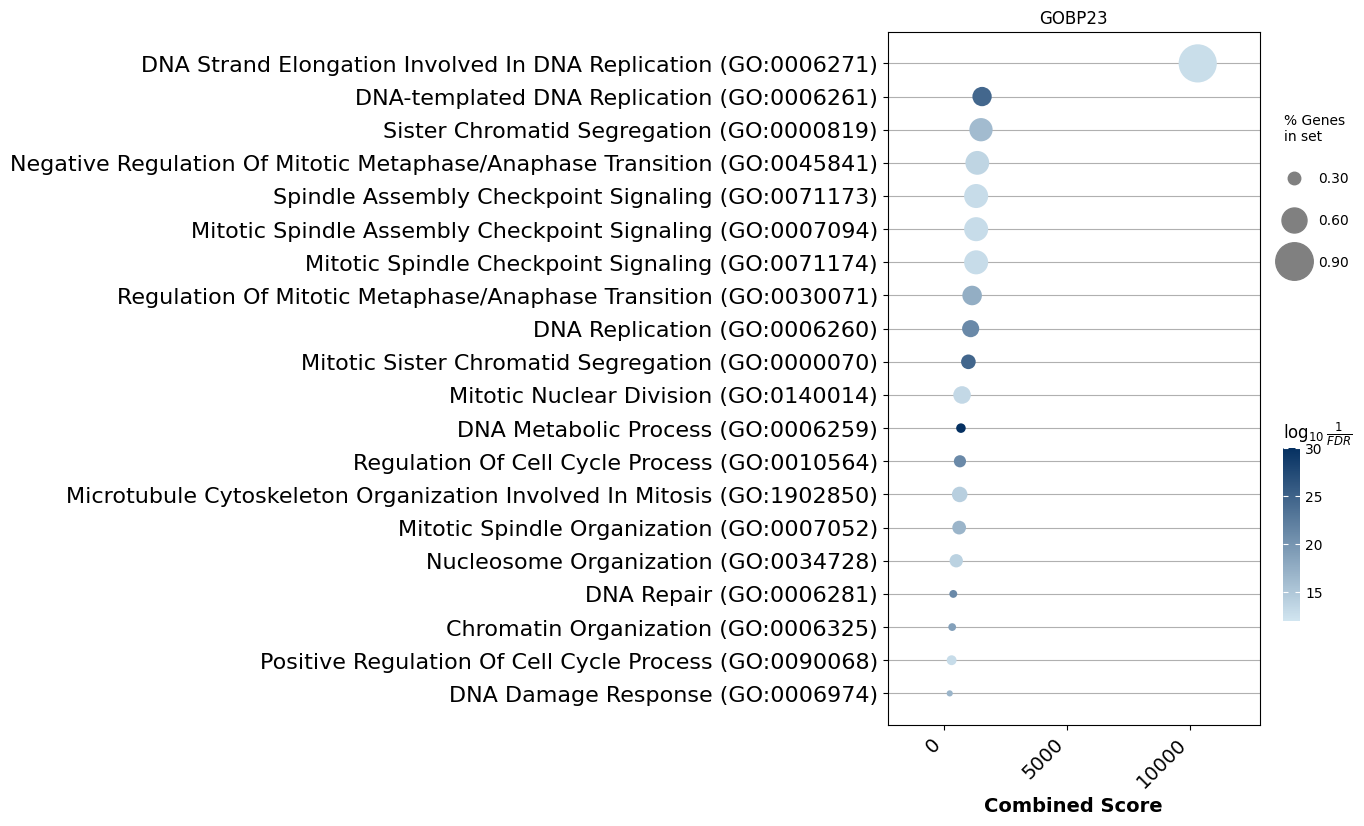

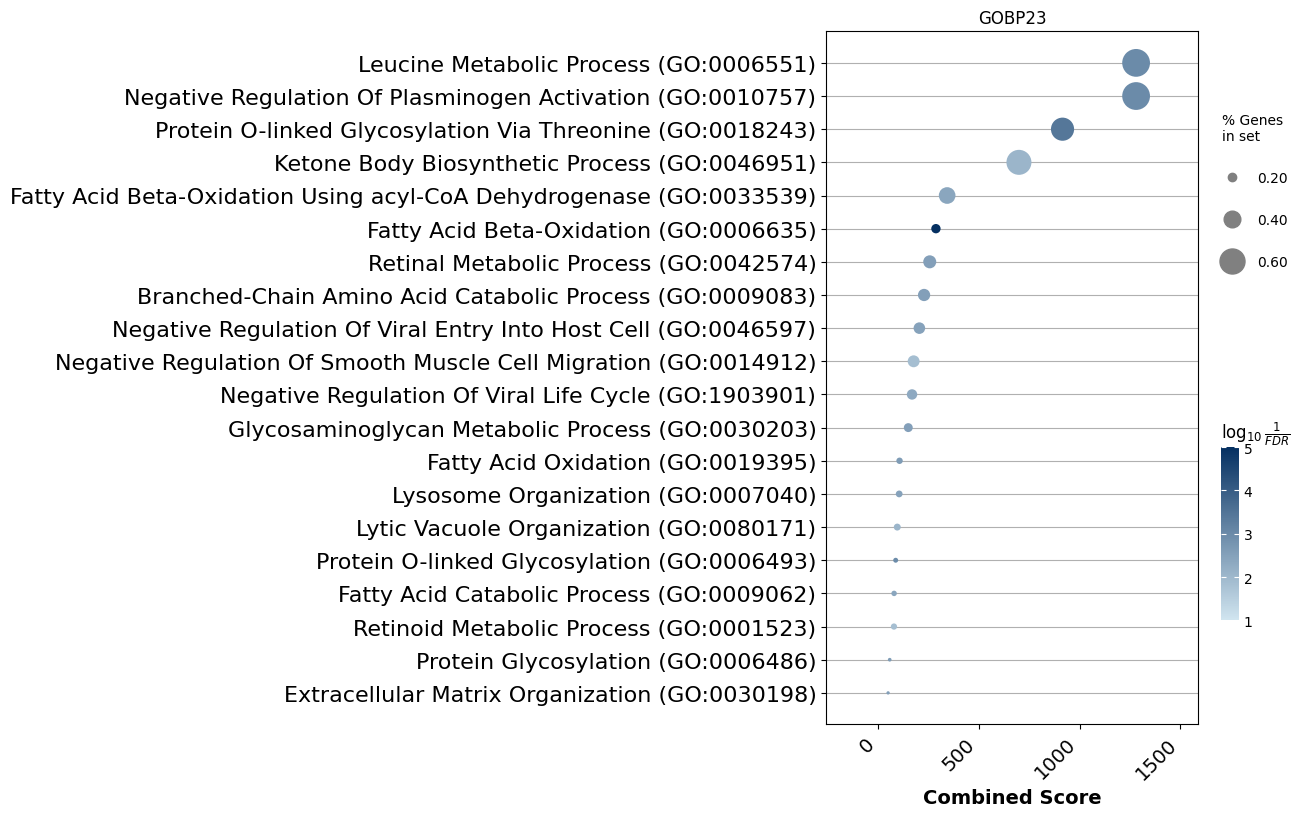

In [62]:
from matplotlib.colors import LinearSegmentedColormap

cmap = LinearSegmentedColormap.from_list('somemap', ['#d1e5f0', '#053061'], N = 256)
# cmap = LinearSegmentedColormap.from_list('somemap', ['#053061', '#f7f7f7', '#67001f', '#fddbc7'], N = 256)
for reg in resobjs.keys():
    res = resobjs[reg].results
    ax = gp.dotplot(
        res,
        size = 5,
        top_term = 20,
        figsize = (6, 9),
        xticklabels_rot = 45, # rotate xtick labels
        marker = 'o',
        cutoff = 0.1,
        cmap = cmap
    )
    ax.set_title(f'GOBP23')
    fig = ax.get_figure()
    fig.savefig(f'../plots/dotplot_gsea_rpe1_GOBP23_{reg}_top20.pdf')

In [66]:
proteomics_down_genes = []
for gene in df[df.bins == 'down'].symbol:
    proteomics_down_genes.extend(gene.split(';'))

In [73]:
top_cluster_score_genes = []
with open('../cluster_scores/top_5.0p_genes_human_cluster_score_w10_a_ending.tsv', 'r') as f:
    for gene in f:
        top_cluster_score_genes.append(gene.rstrip())

In [74]:
len(set(proteomics_down_genes) & set(top_cluster_score_genes))

41

In [75]:
set(proteomics_down_genes) & set(top_cluster_score_genes)

{'AGPAT5',
 'ARGLU1',
 'ARL6IP1',
 'CCNL1',
 'CDCA8',
 'CDK1',
 'CEP55',
 'CEP97',
 'CLGN',
 'CWC27',
 'DEK',
 'DESI2',
 'DLGAP5',
 'EIF5',
 'GMNN',
 'GTF2H1',
 'ING5',
 'KIF11',
 'KPNA1',
 'LARP7',
 'LUC7L3',
 'LYAR',
 'NDC80',
 'NUCKS1',
 'PHACTR2',
 'PLIN2',
 'POLR1F',
 'PPP1R12A',
 'PPP1R2',
 'PPP1R2B',
 'PPP4R3A',
 'PRPF18',
 'RAB23',
 'RAB8B',
 'SMARCE1',
 'SPDL1',
 'TERF2IP',
 'TMED5',
 'TMEM97',
 'VANGL1',
 'VEZF1'}